In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys
from sklearn.metrics import r2_score, mean_absolute_error


sys.path.append("src")
from utils import load_fred_csv
from utils import display_correlation_matrix
from utils import trend_accuracy

In [2]:
case_shiller_index_path = "data/case_shiller_index.csv"
fed_rate_path = "data/Federal_Funds_Effective_Rate.csv"
mortgage_rate_path = "data/Fixed_Rate_Mortgage_Average_United_States.csv"
building_permit_path = "data/building_permit.csv"
housing_starts_path = "data/housing_starts.csv"
new_home_sales_path = "data/new_houses_sold.csv"

df_case_shiller_index = load_fred_csv(case_shiller_index_path, "CSUSHPINSA", "case_shiller_value") # par mois
df_fed_rate = load_fred_csv(fed_rate_path, "FEDFUNDS", "fed_rate") # par mois
df_mortgage_rate = load_fred_csv(mortgage_rate_path, "MORTGAGE30US", "mortgage_rate") # par semaine
df_building_permit = load_fred_csv(building_permit_path, "PERMIT", "building_permits") # par mois
df_housing_starts = load_fred_csv(housing_starts_path, "HOUST", "housing_starts") # par mois
df_new_home_sales = load_fred_csv(new_home_sales_path, "HSN1FNSA", "new_home_sales") # par mois


In [3]:
# interpolate the mortgage rate to monthly frequency
df_mortgage_rate = df_mortgage_rate.resample('MS', on='date').mean()
df_mortgage_rate = df_mortgage_rate.reset_index()

In [4]:
# Fusion de toutes les séries sur la date
df_immobilier = df_case_shiller_index \
    .merge(df_fed_rate, on="date", how="inner") \
    .merge(df_mortgage_rate, on="date", how="inner") \
    .merge(df_building_permit, on="date", how="inner") \
    .merge(df_housing_starts, on="date", how="inner") \
    .merge(df_new_home_sales, on="date", how="inner")


In [5]:
# Création des variables dérivées (% d'évolution mensuelle)
df_immobilier["cs_growth"] = df_immobilier["case_shiller_value"].pct_change() * 100
df_immobilier["building_permits_growth"] = df_immobilier["building_permits"].pct_change() * 100
df_immobilier["new_home_sales_growth"] = df_immobilier["new_home_sales"].pct_change() * 100
df_immobilier["housing_starts_growth"] = df_immobilier["housing_starts"].pct_change() * 100
df_immobilier["fed_rate_growth"] = df_immobilier["fed_rate"].pct_change() * 100
df_immobilier["mortgage_rate_growth"] = df_immobilier["mortgage_rate"].pct_change() * 100

# Nettoyage : supprimer les lignes avec NaN (dus aux pct_change ou lag)
df_immobilier = df_immobilier.dropna().reset_index(drop=True)

In [6]:
df_immobilier.head()

date  case_shiller_value  fed_rate  mortgage_rate  building_permits  \
0 1987-02-01              64.133      6.10         9.0825              1689   
1 1987-03-01              64.468      6.13         9.0350              1704   
2 1987-04-01              64.972      6.37         9.8325              1601   
3 1987-05-01              65.547      6.85        10.5960              1500   
4 1987-06-01              66.218      6.73        10.5375              1522   

   housing_starts  new_home_sales  cs_growth  building_permits_growth  \
0            1784              59   0.627618                -0.059172   
1            1726              73   0.522352                 0.888099   
2            1614              72   0.781783                -6.044601   
3            1628              62   0.884997                -6.308557   
4            1594              58   1.023693                 1.466667   

   new_home_sales_growth  housing_starts_growth  fed_rate_growth  \
0              11.320755               0.563698        -5.132193   
1              23.728814              -3.251121         0.491803   
2              -1.369863              -6.488992         3.915171   
3             -13.888889               0.867410         7.535322   
4              -6.451613              -2.088452        -1.751825   

   mortgage_rate_growth  
0             -1.320078  
1             -0.522984  
2              8.826785  
3              7.765065  
4             -0.552095

In [7]:
# Sélectionner les colonnes numériques à standardiser (hors "date")
cols_to_standardize = [
    "new_home_sales",
    "building_permits",
    "housing_starts",
    "mortgage_rate",
    "fed_rate",
    "case_shiller_value",
    "cs_growth",
    "fed_rate_growth",
    "mortgage_rate_growth",
    "building_permits_growth",
    "new_home_sales_growth",
    "housing_starts_growth",
]

# Standardisation (z-score)
scaler = StandardScaler()
df_std = df_immobilier[["date"]].copy()
df_std[cols_to_standardize] = scaler.fit_transform(df_immobilier[cols_to_standardize])

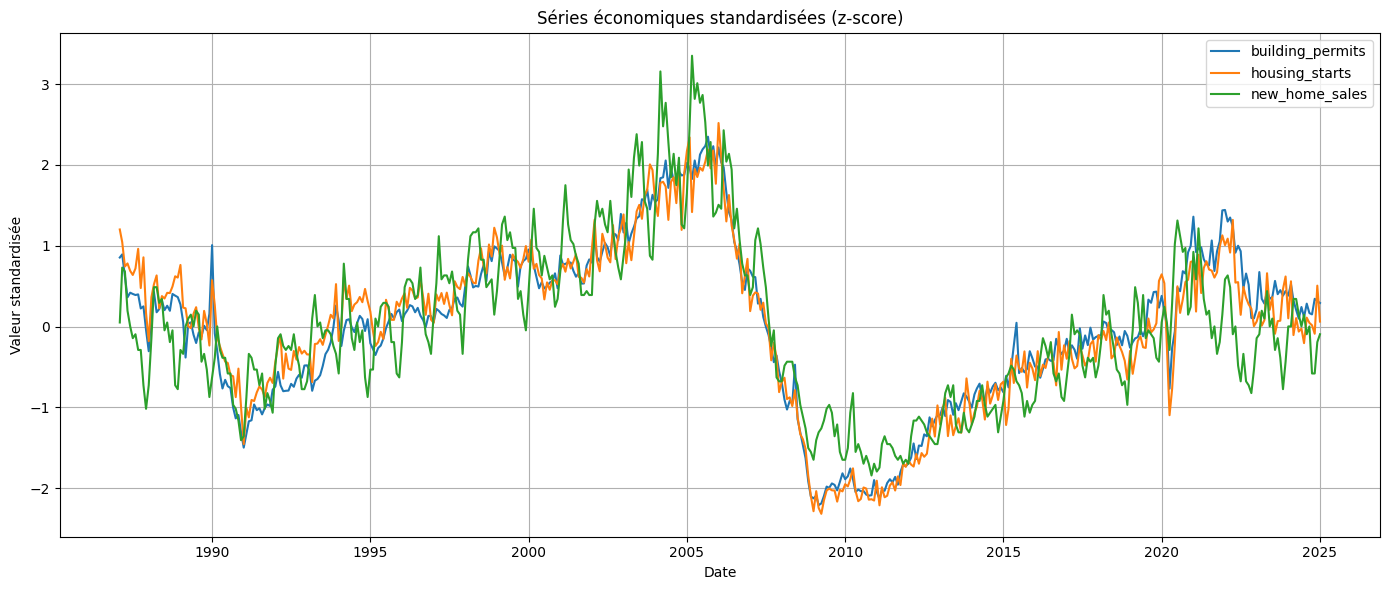

In [8]:
cols_to_plot = ["building_permits", "housing_starts", "new_home_sales"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_std["date"], df_std[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

On remarque que les 3 ont la même tendance donc on se permet de visualiser juste la moins bruité parmie eux (building_permits).

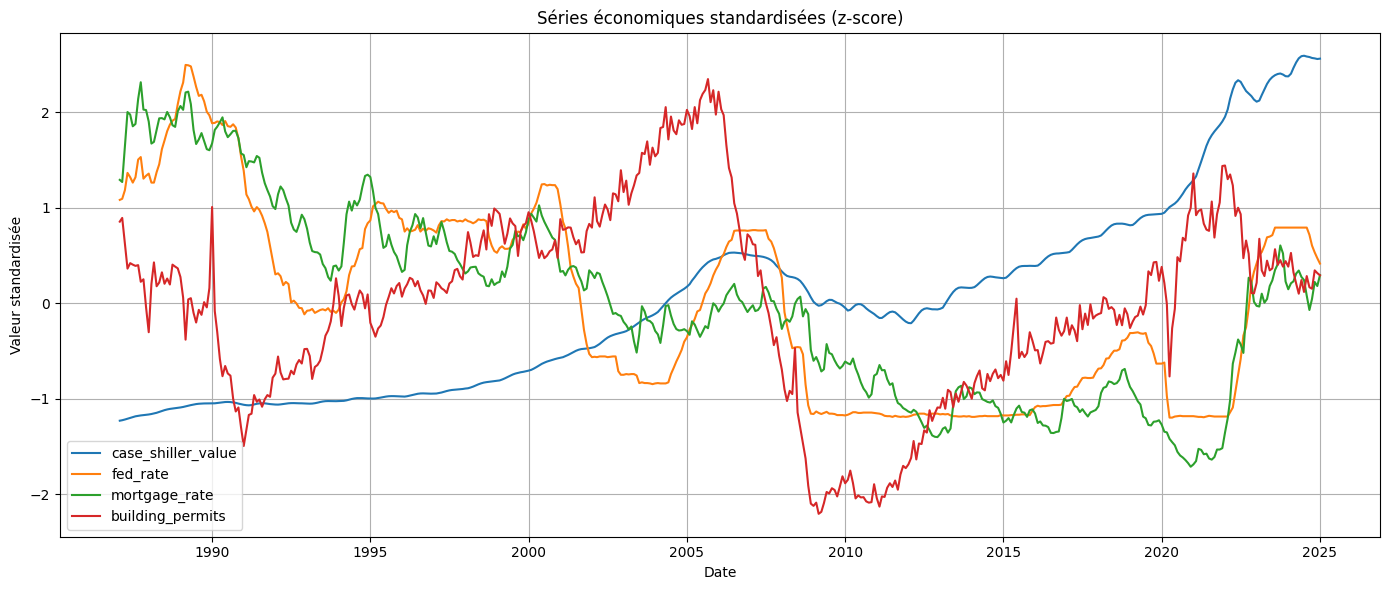

In [9]:
cols_to_plot = ["case_shiller_value", "fed_rate", "mortgage_rate", "building_permits"]

plt.figure(figsize=(14, 6))
for col in cols_to_plot:
    plt.plot(df_std["date"], df_std[col], label=col)

plt.title("Séries économiques standardisées (z-score)")
plt.xlabel("Date")
plt.ylabel("Valeur standardisée")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

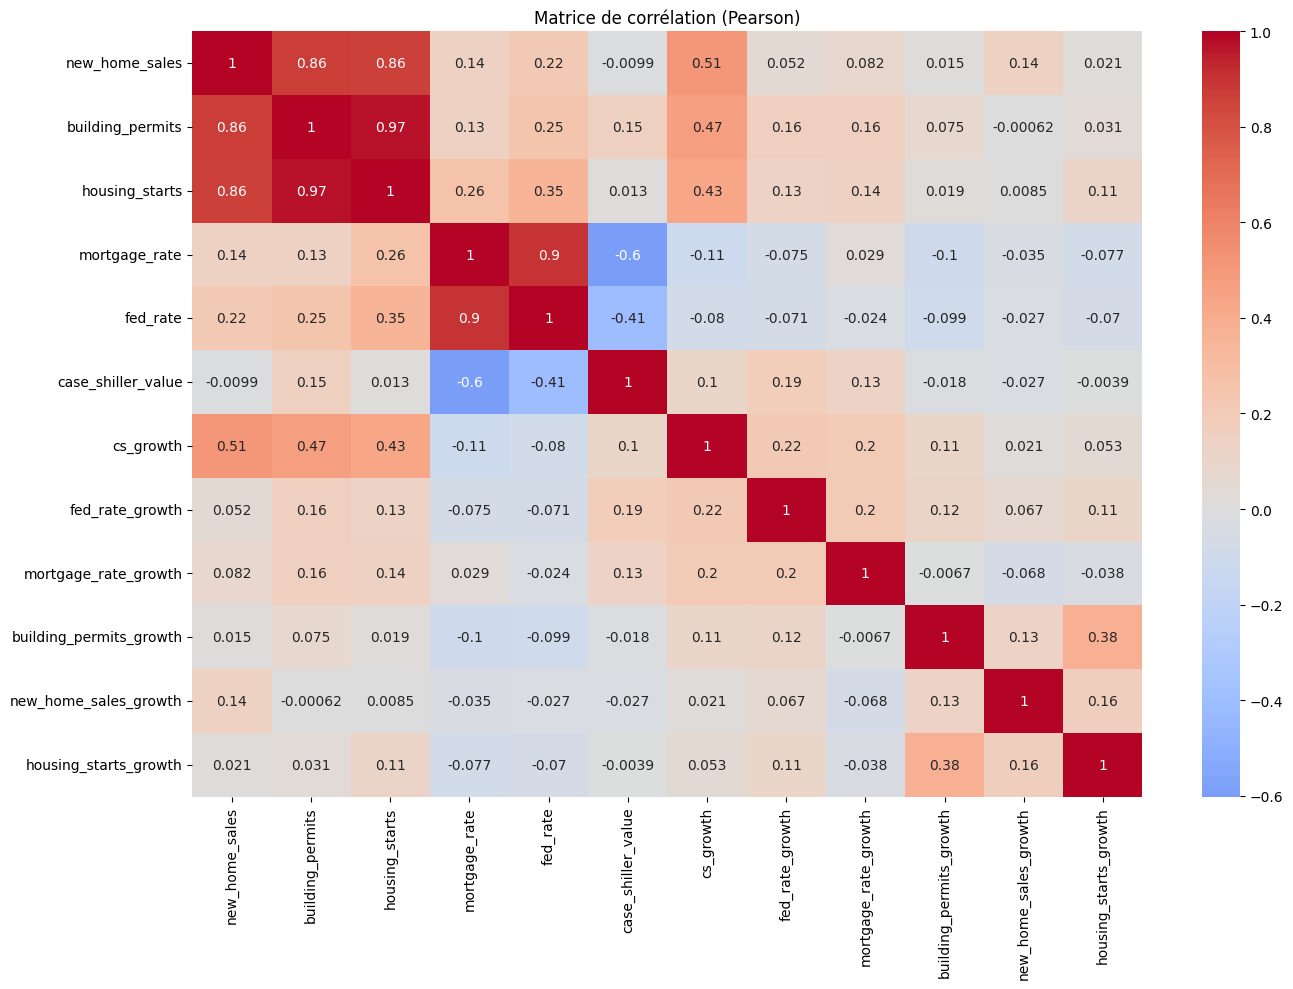

In [10]:
# Tu sélectionnes toutes les colonnes numériques pertinentes
corr_matrix = df_std.drop(columns=["date"]).corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True)
plt.title("Matrice de corrélation (Pearson)")
plt.tight_layout()
plt.show()

### Corrélation entre indicateurs immobiliers :
- `new_home_sales` et `building_permits` : **corrélation de 0.86**  
  ⇒ Très forte corrélation positive. Cela montre que la vente de maisons neuves suit de près l’activité de construction.

- `building_permits` et `housing_starts` : **0.97**  
  ⇒ Les deux variables sont quasiment identiques. Inutile de les garder toutes les deux dans un modèle.

- `new_home_sales` et `housing_starts` : **0.86**  
  ⇒ Relation également très forte. Ces trois indicateurs ont la même dynamique.

**Conclusion** : ces variables racontent toutes la même chose. Pour un modèle, on peut en garder une seule (par exemple `building_permits`) pour éviter la redondance.


### Corrélation avec les taux d’intérêt :
- entre `mortgage_rate` et `case_shiller_value` : -0.60 ⇒ Quand les taux montent, les prix baissent donc cohérent avec l’hypothèse
- entre `fed_rate` et `case_shiller_value` : -0.41 ⇒ Même effet, mais plus faible que `mortgage_rate`
- entre `mortgage_rate` et `housing_starts`	: 0.26	⇒ (surprenant)	Possible qu’il y ait un effet différé non pris en compte ici
- entre `fed_rate` et `housing_starts` : 0.35 ⇒ (surprenant aussi)	Cela peut cacher un effet indirect ou un biais temporel

### Correlation avec case shiller (index sur les prix des maisons) :
- `new_home_sales` : 0.51	⇒ Quand les ventes de maisons augmentent, la croissance des prix immobiliers a tendance à augmenter aussi (relation positive). C’est une corrélation modérée à forte.
- `building_permits` : 0.47 ⇒ Quand il y a plus de permis de construire, les prix tendent aussi à augmenter (corrélation moyenne). Peut être car plus de permis = demande active.
- `housing_starts` : 0.43 ⇒ Plus de chantiers lancés donc prix qui augmentent aussi, mais un peu moins que les deux précédents.



In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Copie de base du DataFrame initial
df_base = df_immobilier.copy()
df_base = df_base.drop(columns=["new_home_sales", "housing_starts"])

# Colonnes à décaler
cols_to_lag = [
    "mortgage_rate",
    "fed_rate",
    "building_permits",
    "case_shiller_value",
    "cs_growth",
    "fed_rate_growth",
    "building_permits_growth",
    "mortgage_rate_growth"
]

# Dictionnaire des types de lags
lag_dict = {
    "short": [3, 6, 12],
    "medium": [16, 24, 30],
    "long": [36, 42, 48],
    "very_long": [54, 60, 66]
}

# Fonction pour générer un DataFrame avec lags + standardisation
def create_lagged_df(df, lag_list, name=None):
    df_lagged = df.copy()
    
    # Création des colonnes décalées
    for col in cols_to_lag:
        for lag in lag_list:
            df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    
    # Nettoyage des NaN
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    
    # Colonnes à standardiser
    features_to_standardize = [col for col in df_lagged.columns if "lag" in col]
    features_to_standardize += cols_to_lag

    # Standardisation
    scaler = StandardScaler()
    df_std = df_lagged[["date"]].copy()
    df_std[features_to_standardize] = scaler.fit_transform(df_lagged[features_to_standardize])

    return df_std

# Création des trois DataFrames
df_immobilier_short = create_lagged_df(df_base, lag_dict["short"], "short")
df_immobilier_medium = create_lagged_df(df_base, lag_dict["medium"], "medium")
df_immobilier_long = create_lagged_df(df_base, lag_dict["long"], "long")
df_immobilier_very_long = create_lagged_df(df_base, lag_dict["very_long"], "very_long")


we need to pay attention to data leakage here, the standard scalar should not be fitted to test data.

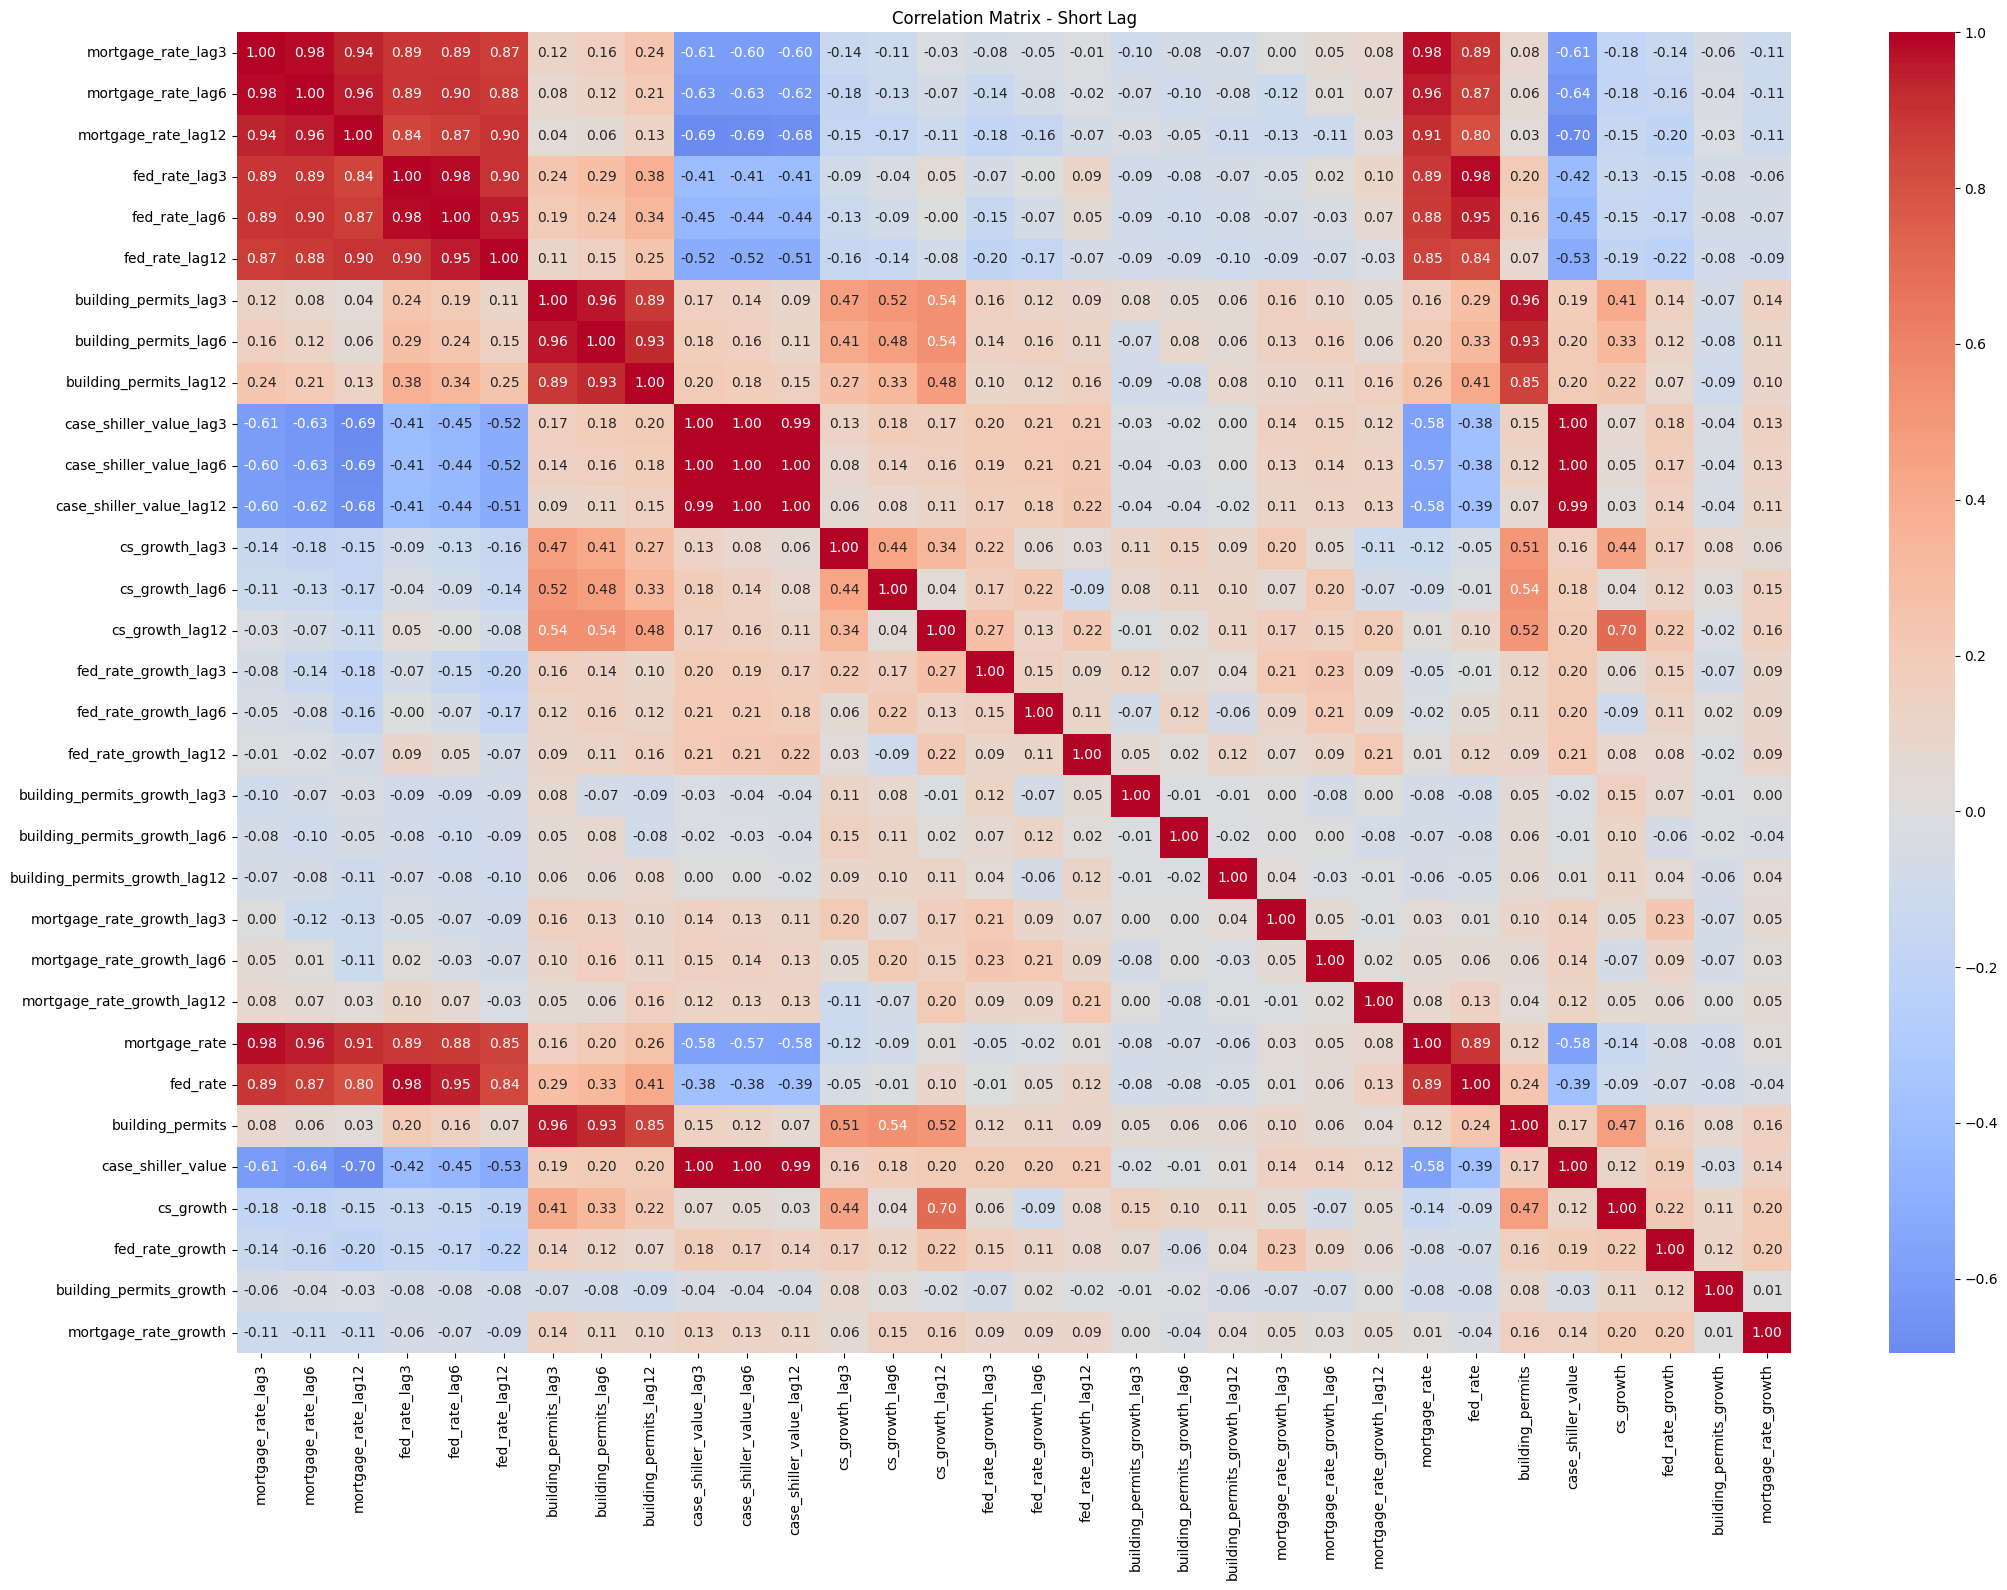

In [12]:
display_correlation_matrix(df_immobilier_short, "Correlation Matrix - Short Lag", figsize=(22, 16))

Attention! Pour éviter de se perdre dans ces grosses matrices on regarde juste les colonnes des variables initiales non décalées. Parce que si X_lag_3 est corrélée avec Y_lag_6, alors X est corrélé avec Y_lag_3.

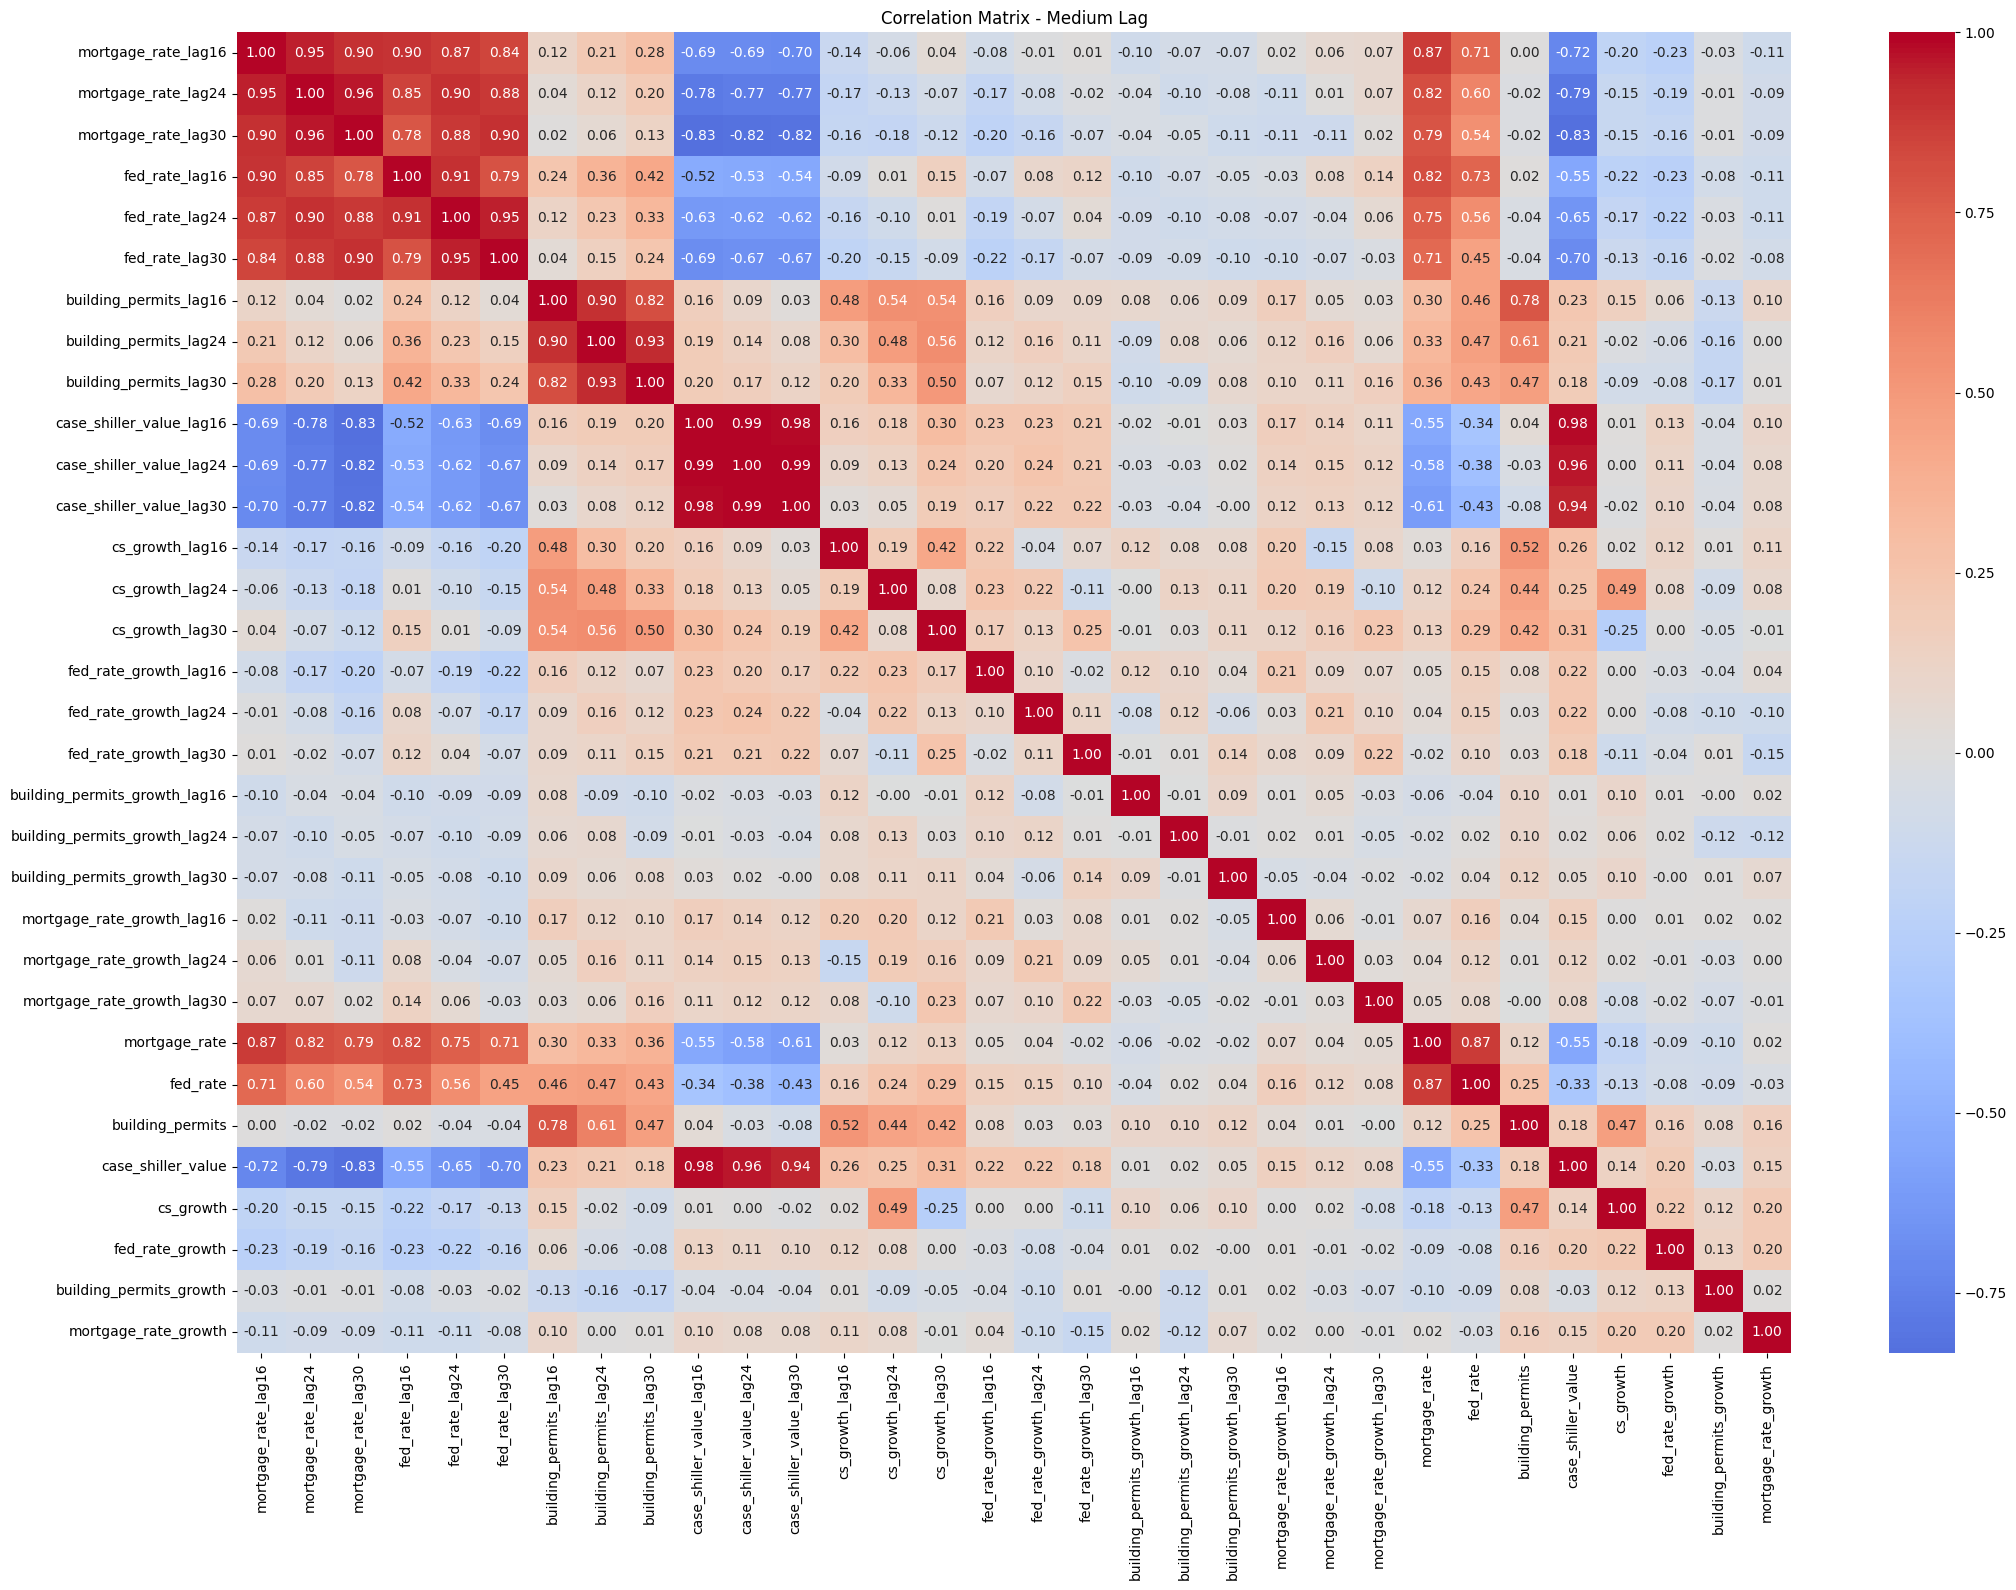

In [13]:
# testons des lags plus longs pour voir si on a plus de corrélations
display_correlation_matrix(df_immobilier_medium, "Correlation Matrix - Medium Lag", figsize=(22, 16))

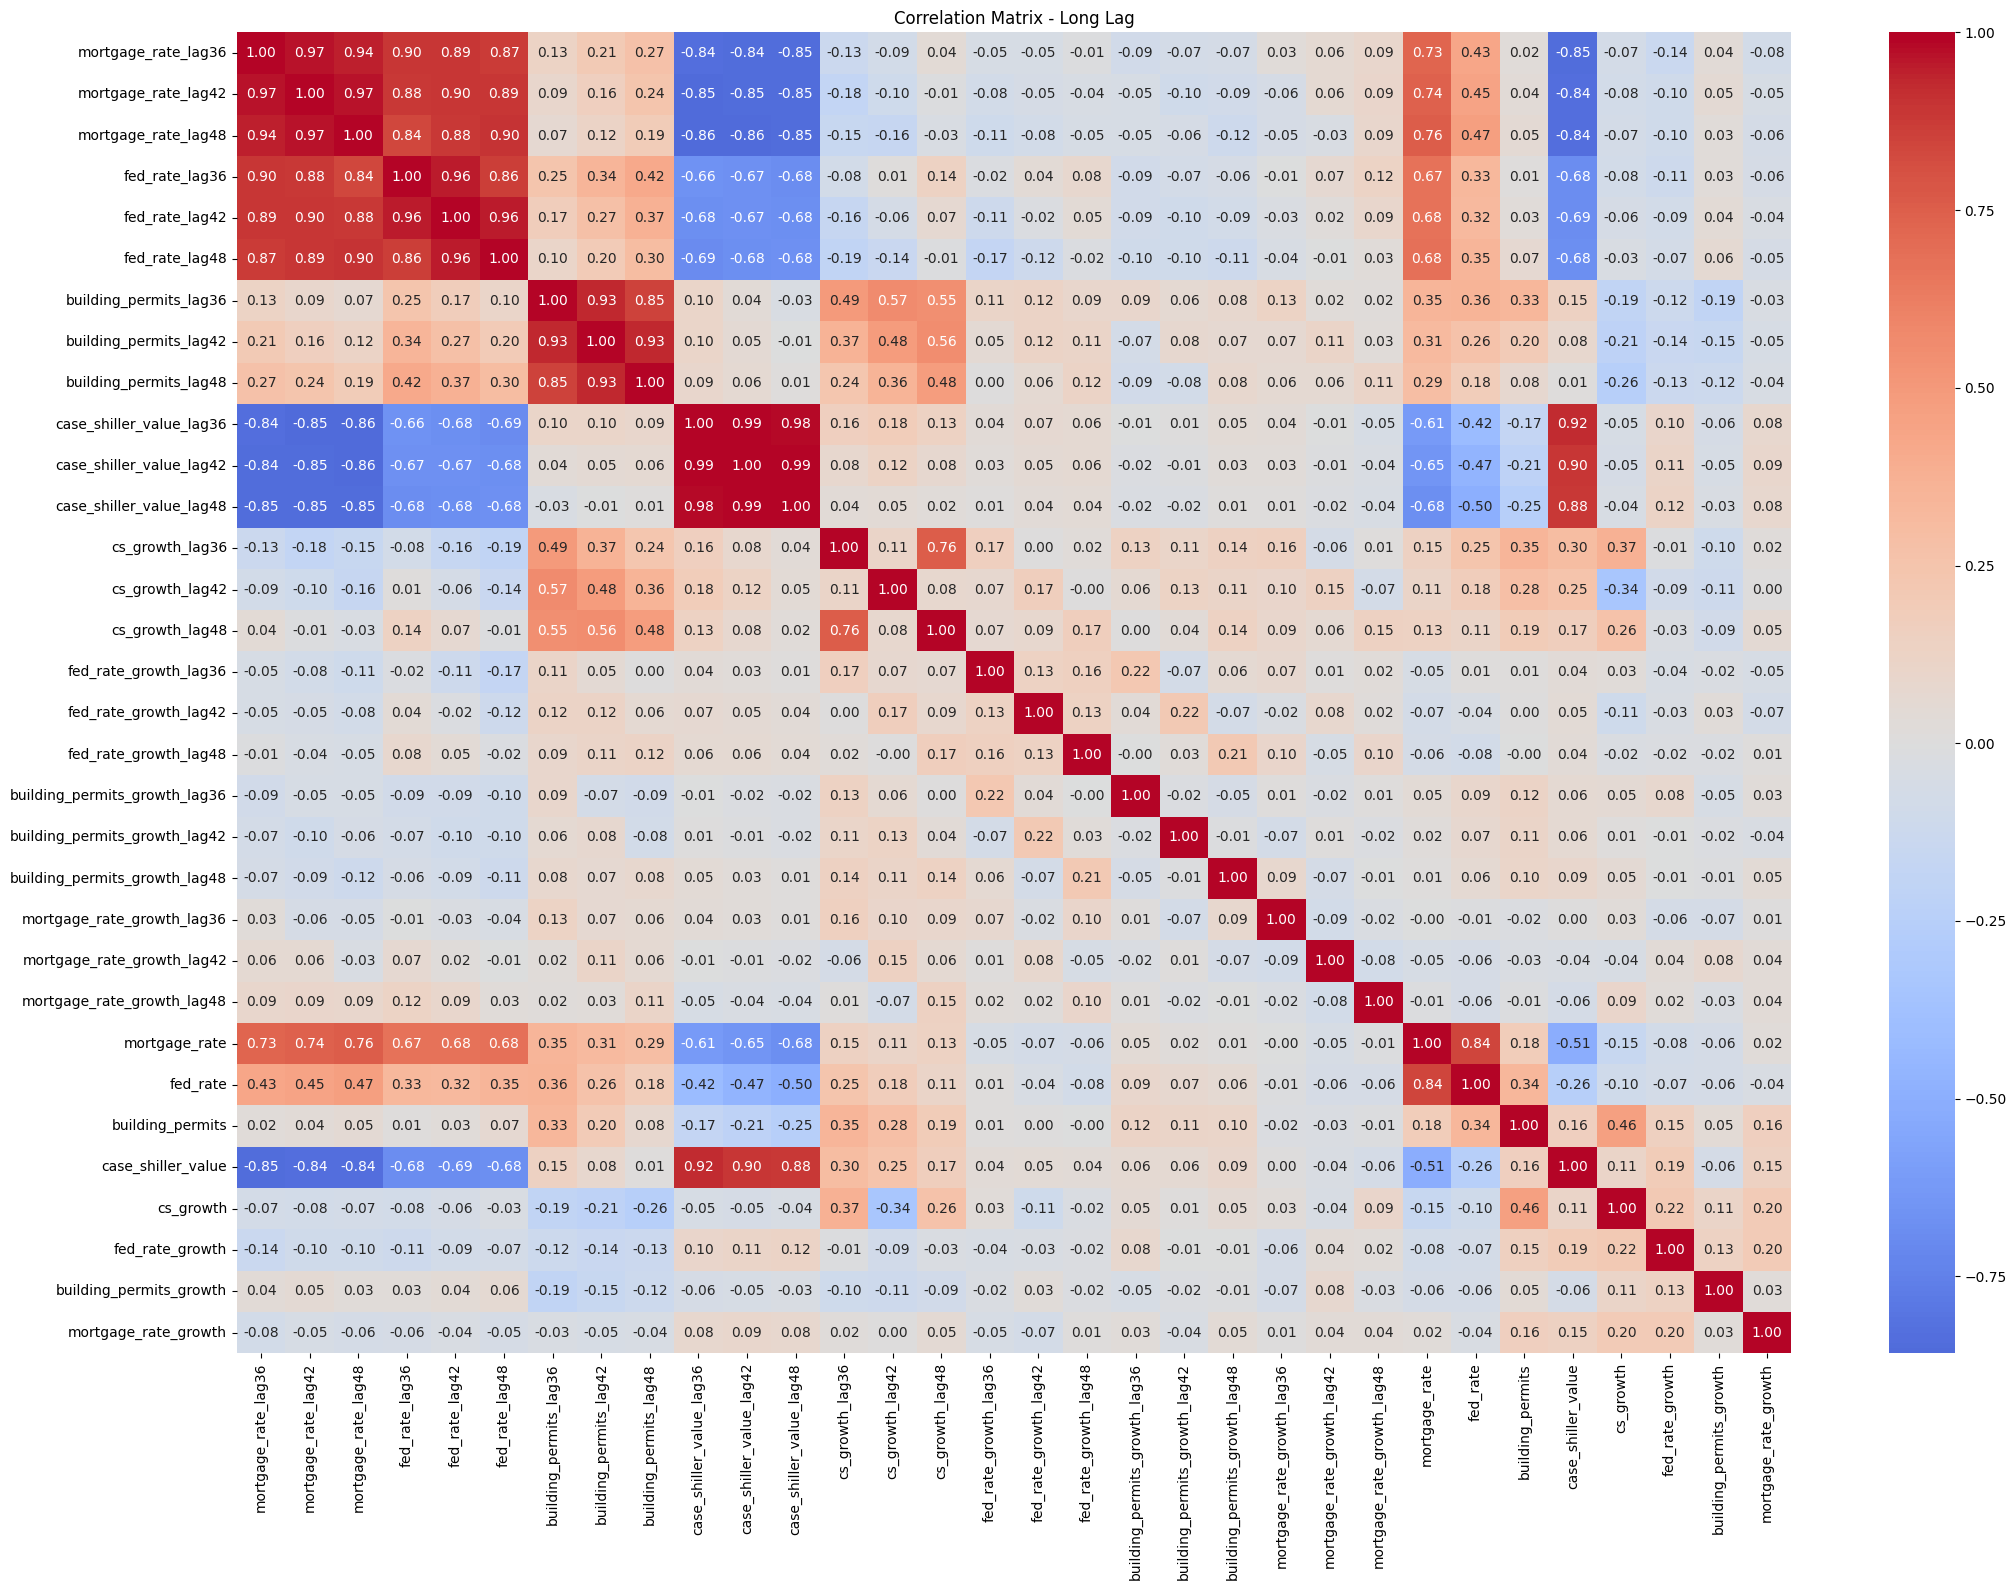

In [14]:
display_correlation_matrix(df_immobilier_long, "Correlation Matrix - Long Lag", figsize=(22,16))

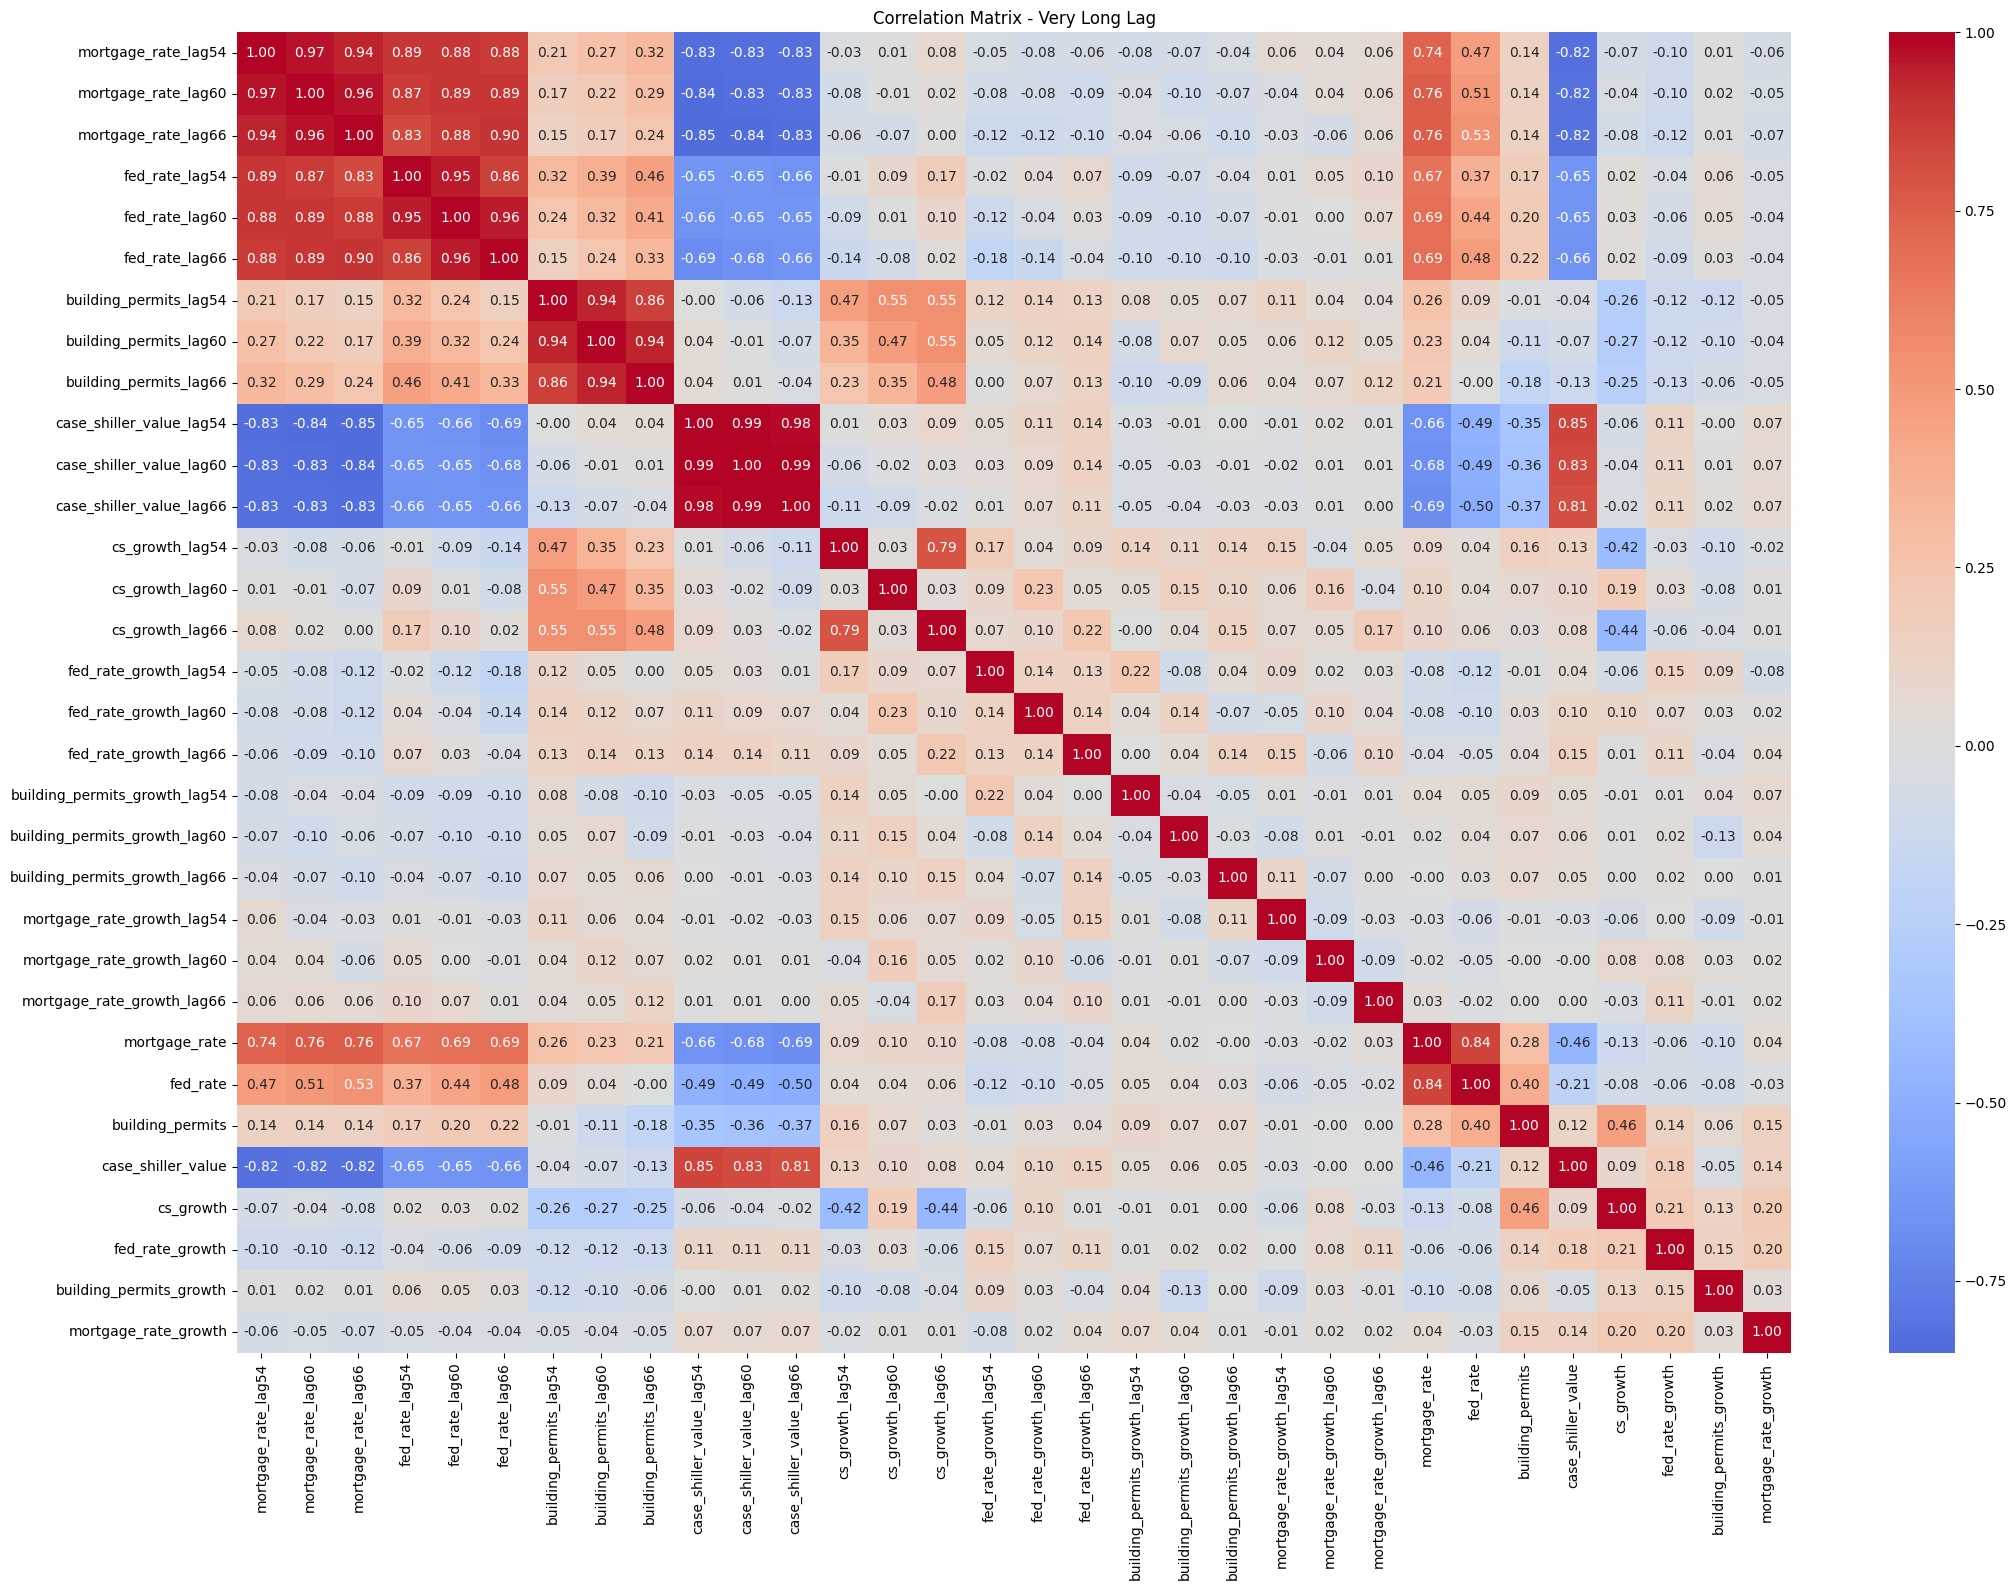

In [15]:
display_correlation_matrix(df_immobilier_very_long, "Correlation Matrix - Very Long Lag", figsize=(22,16))

## 1. Taux d’intérêt et prix immobiliers (relation directe et avec lags)

### Corrélation contemporaine (sans décalage)
- `mortgage_rate` et `case_shiller_value` : **−0.60**  
  ⇒ Quand les taux hypothécaires montent, les prix immobiliers baissent. Cela confirme notre hypothèse.

- `fed_rate` et `case_shiller_value` : **−0.41**  
  ⇒ Même effet mais un peu plus faible. Moins direct que les taux hypothécaires.

### Avec décalage de 12 mois
- `mortgage_rate_lag12` et `case_shiller_value` : **−0.70**  
  ⇒ L’effet négatif des taux devient plus fort après un an. Cela correspond bien à la réalité économique : hausse des taux aujourd’hui → baisse des prix plus tard.

- `fed_rate_lag12` et `case_shiller_value` : **−0.53**  
  ⇒ Même logique : les prix réagissent avec un certain délai aux décisions de la Fed.

### Avec décalage de 24 mois
- `mortgage_rate_lag24` et `case_shiller_value` : **−0.79**  
- `fed_rate_lag24` et `case_shiller_value` : **−0.65**  
    ⇒ Même logique

### Avec décalage de 36 mois
- `mortgage_rate_lag36` et `case_shiller_value` : **−0.85**  
- `fed_rate_lag36` et `case_shiller_value` : **−0.69**  
  ⇒ Les corrélations sont encore plus fortes, mais faut faire attention car ce décalage de 3 ans réduit beaucoup la taille de l’échantillon. Les résultats sont donc un peu **moins fiables**.

**Conclusion** :  
→ Hausse des taux → crédit plus cher → moins d’acheteurs → pression baissière sur les prix.  
→ L’effet est plus visible avec un délai. Cela **confirme l’hypothèse de départ** : *les taux hypothécaires tuent la capacité d’achat, ce qui provoque une chute de l’activité immobilière*.

---

## 2. Réaction de la Fed à l’activité économique

- `building_permits_lag12` et `fed_rate` : **+0.41**  
  ⇒ Quand l’activité immobilière était élevée il y a un an (plus de permis de construire), la Fed a tendance à **augmenter ses taux** aujourd’hui. Cela reflète une réaction de la politique monétaire à une économie qui “chauffe”.

> Beaucoup de constructions, de ventes, d’investissements → économie en forme → risque d’inflation → le Fed monte les taux pour ralentir.

Cela montre bien que **la Fed réagit à l’activité réelle avec un certain délai**.

---

## 3. Effet d’inertie (persistance des séries)

- `fed_rate` et `fed_rate_lag3` : **0.98**  
  ⇒ Le taux directeur varie très lentement dans le temps. La politique monétaire suit une trajectoire stable et progressive.

- `mortgage_rate` et `mortgage_rate_lag3` : **0.98**  
  ⇒ Même comportement : le taux hypothécaire change doucement.

- `case_shiller_value` et `case_shiller_value_lag12` : **0.99**  
  ⇒ Très forte inertie des prix immobiliers. S’ils montent aujourd’hui, ils montent souvent encore un an après.

- `cs_growth` et `cs_growth_lag12` : **0.70**  
  ⇒ Même chose pour la croissance des prix. Si les prix augmentent maintenant, il y a de grandes chances qu’ils continuent d’augmenter l’année suivante.

> Cela ne prouve pas une causalité, mais ça montre une **relation stable dans le temps**. On pourrait aller plus loin en testant des modèles auto-régressifs.

---

## 4. Corrélations secondaires ou faibles

- `mortgage_rate_growth` et `cs_growth` : **0.20**
- `fed_rate_growth` et `cs_growth` : **0.22**
- `fed_rate_growth` et `building_permits` : **0.16**
- `mortgage_rate` et `building_permits` : **0.16**
- `building_permits` et `cs_growth_lag6` : **0.54**

Ces corrélations sont plus faibles et parfois peu fiables. Elles peuvent indiquer des relations intéressantes mais pas très solides à exploiter dans un modèle.

---

## 5. À retenir pour le modèle

- Les variables `case_shiller_value`, `mortgage_rate` et `fed_rate` sont **centrales**.
- Les lags de **12, 24 et 36 mois** sont les plus intéressants : ils captent bien l’effet différé des taux.

---

## 6. En résumé

> Quand la Fed monte ses taux aujourd’hui, les effets sur l’immobilier se font sentir un an plus tard : moins de constructions, moins d’acheteurs, et des prix qui stagnent voire baissent. Le marché immobilier a donc besoin de temps pour encaisser le choc, tandis que la Fed ajuste ses taux avec du retard sur l’activité passée.

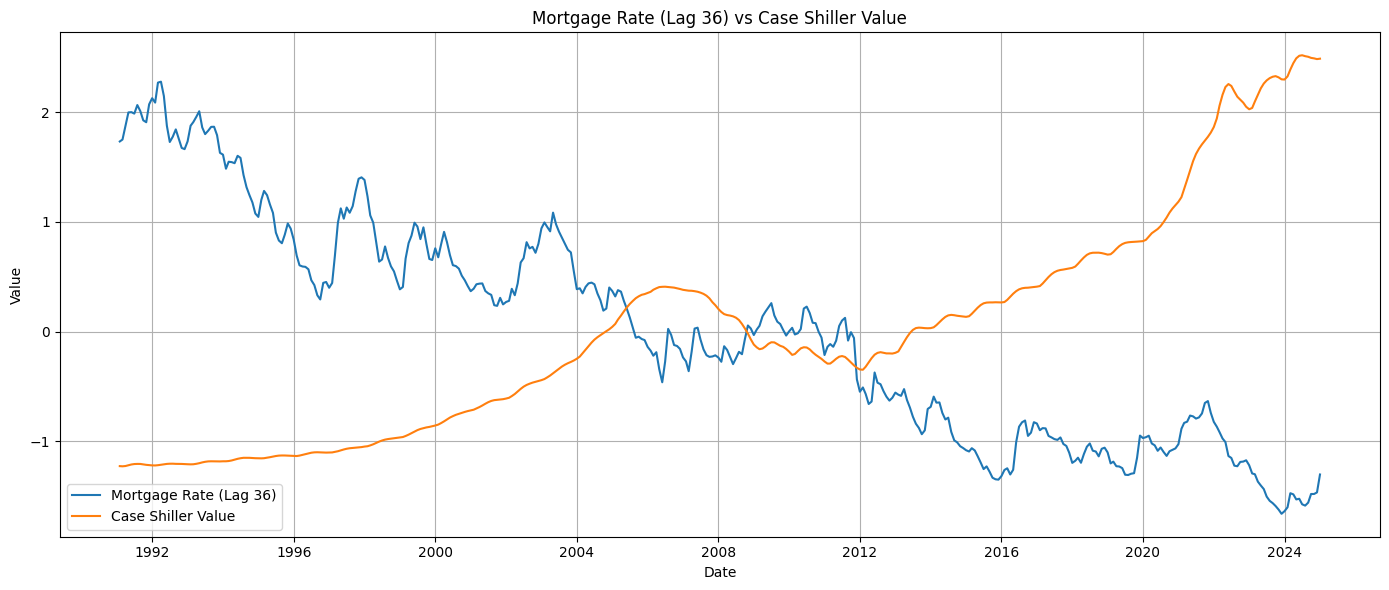

In [16]:
# Visualiser mortgage rate (lag 36) et case shiller sur le meme graphique
plt.figure(figsize=(14, 6))
plt.plot(df_immobilier_long["date"], df_immobilier_long["mortgage_rate_lag36"], label="Mortgage Rate (Lag 36)")
plt.plot(df_immobilier_long["date"], df_immobilier_long["case_shiller_value"], label="Case Shiller Value")
plt.title("Mortgage Rate (Lag 36) vs Case Shiller Value")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

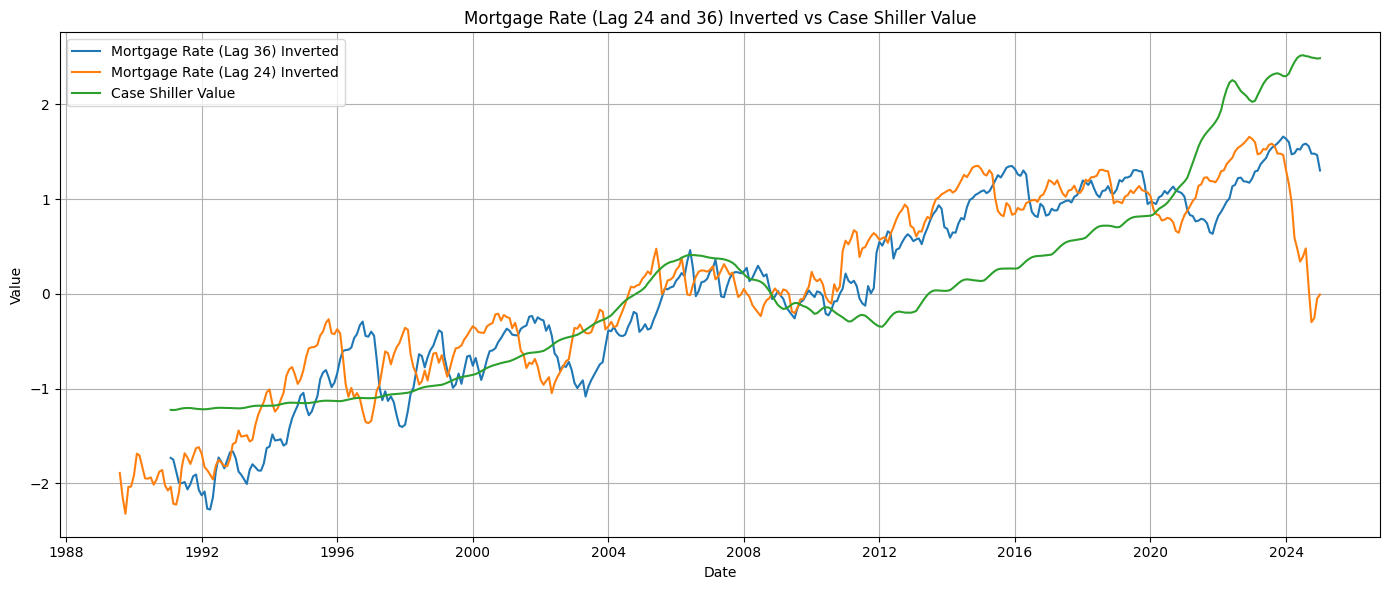

In [17]:
# Visualiser mortgage rate (lag 36) inversé et case shiller sur le meme graphique
plt.figure(figsize=(14, 6))
plt.plot(df_immobilier_long["date"], -df_immobilier_long["mortgage_rate_lag36"], label="Mortgage Rate (Lag 36) Inverted")
plt.plot(df_immobilier_medium["date"], -df_immobilier_medium["mortgage_rate_lag24"], label="Mortgage Rate (Lag 24) Inverted")
plt.plot(df_immobilier_long["date"], df_immobilier_long["case_shiller_value"], label="Case Shiller Value")
plt.title("Mortgage Rate (Lag 24 and 36) Inverted vs Case Shiller Value")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


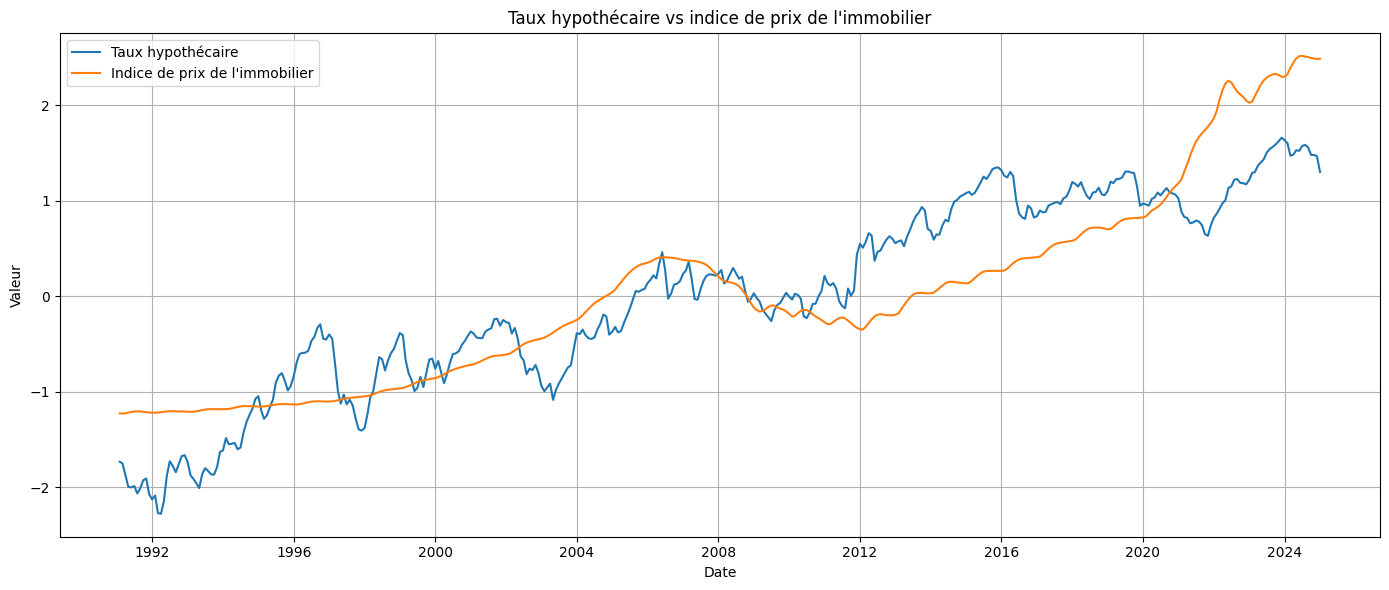

In [18]:
# Visualiser mortgage rate (lag 36) inversé et case shiller sur le meme graphique
plt.figure(figsize=(14, 6))
plt.plot(df_immobilier_long["date"], -df_immobilier_long["mortgage_rate_lag36"], label="Taux hypothécaire")
# plt.plot(df_immobilier_medium["date"], -df_immobilier_medium["mortgage_rate_lag24"], label="Mortgage Rate (Lag 24) Inverted")
plt.plot(df_immobilier_long["date"], df_immobilier_long["case_shiller_value"], label="Indice de prix de l'immobilier")
plt.title("Taux hypothécaire vs indice de prix de l'immobilier")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


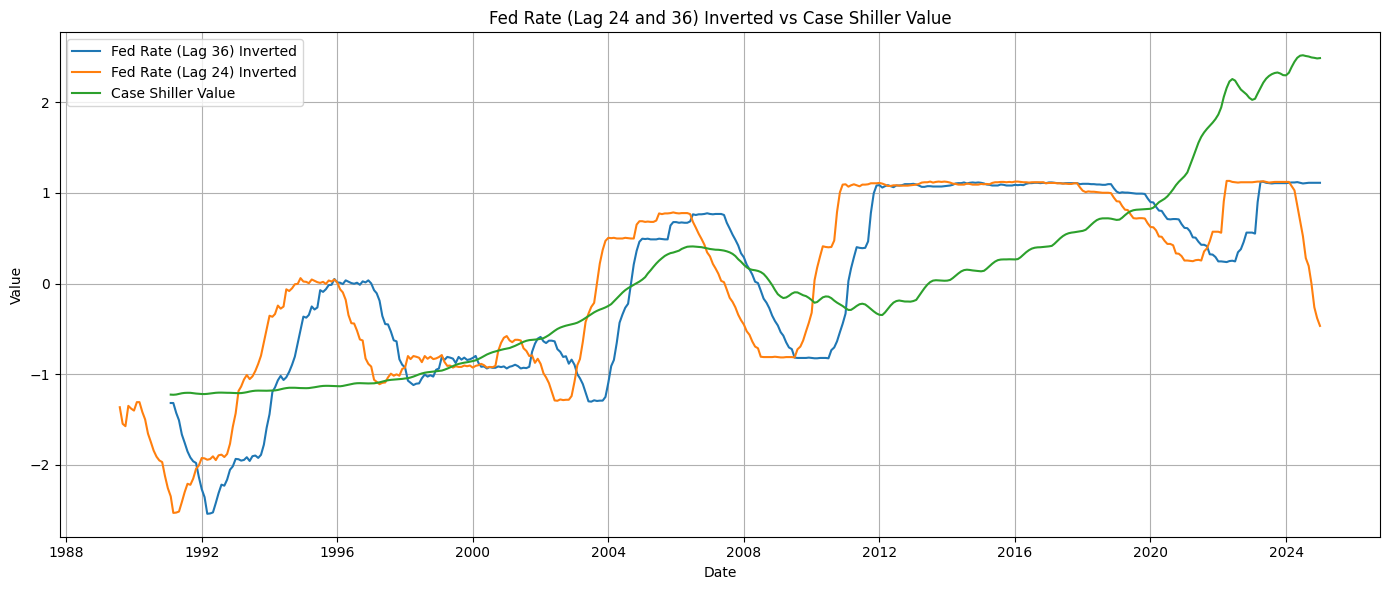

In [19]:
# Visualiser fed rate (lag 24 et 36) inversé et case shiller sur le meme graphique
plt.figure(figsize=(14, 6))
plt.plot(df_immobilier_long["date"], -df_immobilier_long["fed_rate_lag36"], label="Fed Rate (Lag 36) Inverted")
plt.plot(df_immobilier_medium["date"], -df_immobilier_medium["fed_rate_lag24"], label="Fed Rate (Lag 24) Inverted")
plt.plot(df_immobilier_long["date"], df_immobilier_long["case_shiller_value"], label="Case Shiller Value")
plt.title("Fed Rate (Lag 24 and 36) Inverted vs Case Shiller Value")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


L'indice des prix des maisons est mieux expliqué avec le mortage rate qu'avec le fed rate mais on va quand même utilisé les deux dans notre modèle predictif car notre hypothèse de départ concerne le fed rate.

# Modèle prédictif

In [20]:
import statsmodels.api as sm

# Copie du DataFrame pour garder df_immobilier intact
df_temp = df_immobilier[["case_shiller_value", "mortgage_rate"]].copy()

# Création de la variable décalée
df_temp["mortgage_rate_lag24"] = df_temp["mortgage_rate"].shift(24)

# On retire les lignes avec des NaN
df_model = df_temp[["case_shiller_value", "mortgage_rate_lag24"]].dropna()

# Variables X et y
y = df_model["case_shiller_value"]
X = df_model[["mortgage_rate_lag24"]]

# Ajout d'une constante (intercept)
X = sm.add_constant(X)

# Régression linéaire
model = sm.OLS(y, X).fit()

# Résumé
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     case_shiller_value   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     734.0
Date:                Thu, 15 May 2025   Prob (F-statistic):           5.04e-95
Time:                        23:16:15   Log-Likelihood:                -2218.1
No. Observations:                 432   AIC:                             4440.
Df Residuals:                     430   BIC:                             4448.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 307.8197    

In [21]:
# Copie du DataFrame pour garder df_immobilier intact
df_temp = df_immobilier[["case_shiller_value", "mortgage_rate"]].copy()

# Création de la variable décalée
df_temp["mortgage_rate_lag36"] = df_temp["mortgage_rate"].shift(36)

# On retire les lignes avec des NaN
df_model = df_temp[["case_shiller_value", "mortgage_rate_lag36"]].dropna()

# Variables X et y
y = df_model["case_shiller_value"]
X = df_model[["mortgage_rate_lag36"]]

# Ajout d'une constante (intercept)
X = sm.add_constant(X)

# Régression linéaire
model = sm.OLS(y, X).fit()

# Résumé
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     case_shiller_value   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1081.
Date:                Thu, 15 May 2025   Prob (F-statistic):          5.63e-118
Time:                        23:16:15   Log-Likelihood:                -2095.4
No. Observations:                 420   AIC:                             4195.
Df Residuals:                     418   BIC:                             4203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 318.9189    

#### Conclusion
- Les deux effets sont fortement négatifs et très significatifs.
- Le modèle avec le taux d’il y a 36 mois explique mieux les variations des prix (R² plus élevé).
- Il est également mieux ajusté selon les critères AIC et BIC.
- Le taux hypothécaire 36 mois en arrière semble être un meilleur prédicteur du marché immobilier actuel.

### Équation de la régression standardisée (pour lag = 36)

On modélise la variable standardisée `case_shiller_value` en fonction de la variable standardisée `mortgage_rate_lag36` :

$$
Z_{\text{case\_shiller}} = \beta_0 + \beta_1 \cdot Z_{\text{mortgage\_rate\_lag\_36}}
$$

Avec :
- $\beta_0$ = 318.92
- $\beta_1$ = -25.92


In [22]:
# Dates dans lesquelles on va tester la régression (on prend les 20% dernières années de chaque période pour le test)
periods = [
    ("1989-01-01", "2000-01-01"),
    ("2000-01-01", "2010-01-01"),
    ("2005-01-01", "2015-01-01"),
    ("2010-01-01", "2020-01-01"),
    ("2015-01-01", "2025-01-01")
]

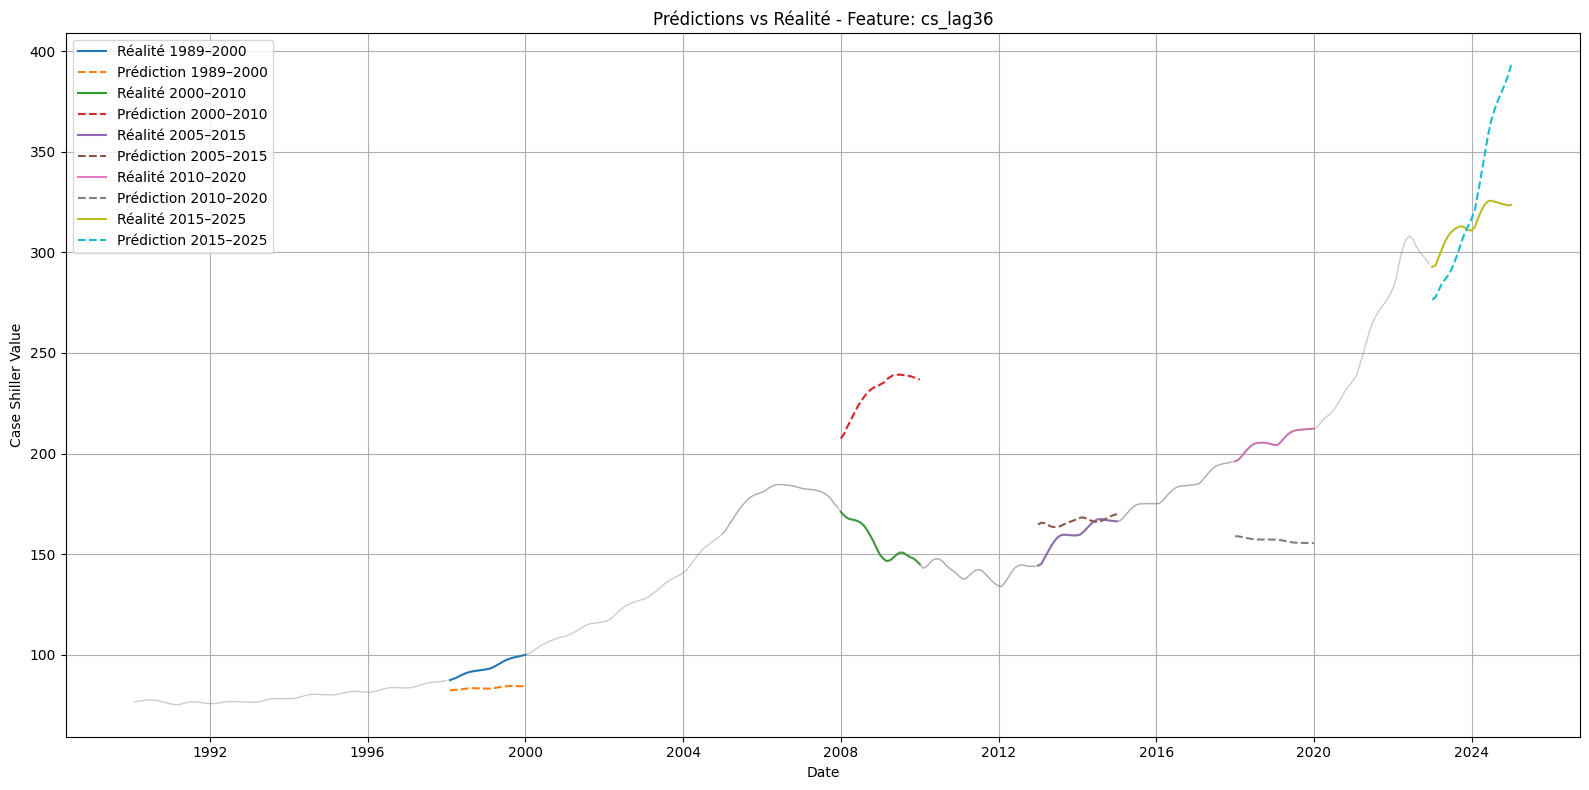

MAE moyen du modèle avec cs_lag36 : 33.3682
R² moyen du modèle avec cs_lag36 : -39.7888
Taux de tendance moyen du modèle avec cs_lag36 : 0.4221


In [23]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "mortgage_rate"]].copy()
df_temp["mortgage_rate_lag36"] = df_temp["mortgage_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(1, 37):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

random_state = 42
# Set the random seed for reproducibility
np.random.seed(random_state)

# Liste pour stocker les R²
r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

# Plot
plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Feature: cs_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["case_shiller_value"]
    X_train = train[["cs_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["cs_lag36"]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_cs36 = np.mean(r2_scores_macro)
trend_model_cs36 = np.mean(trend_scores_macro)
mae_model_cs36 = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec cs_lag36 : {mae_model_cs36:.4f}")
print(f"R² moyen du modèle avec cs_lag36 : {r2_model_cs36:.4f}")
print(f"Taux de tendance moyen du modèle avec cs_lag36 : {trend_model_cs36:.4f}")


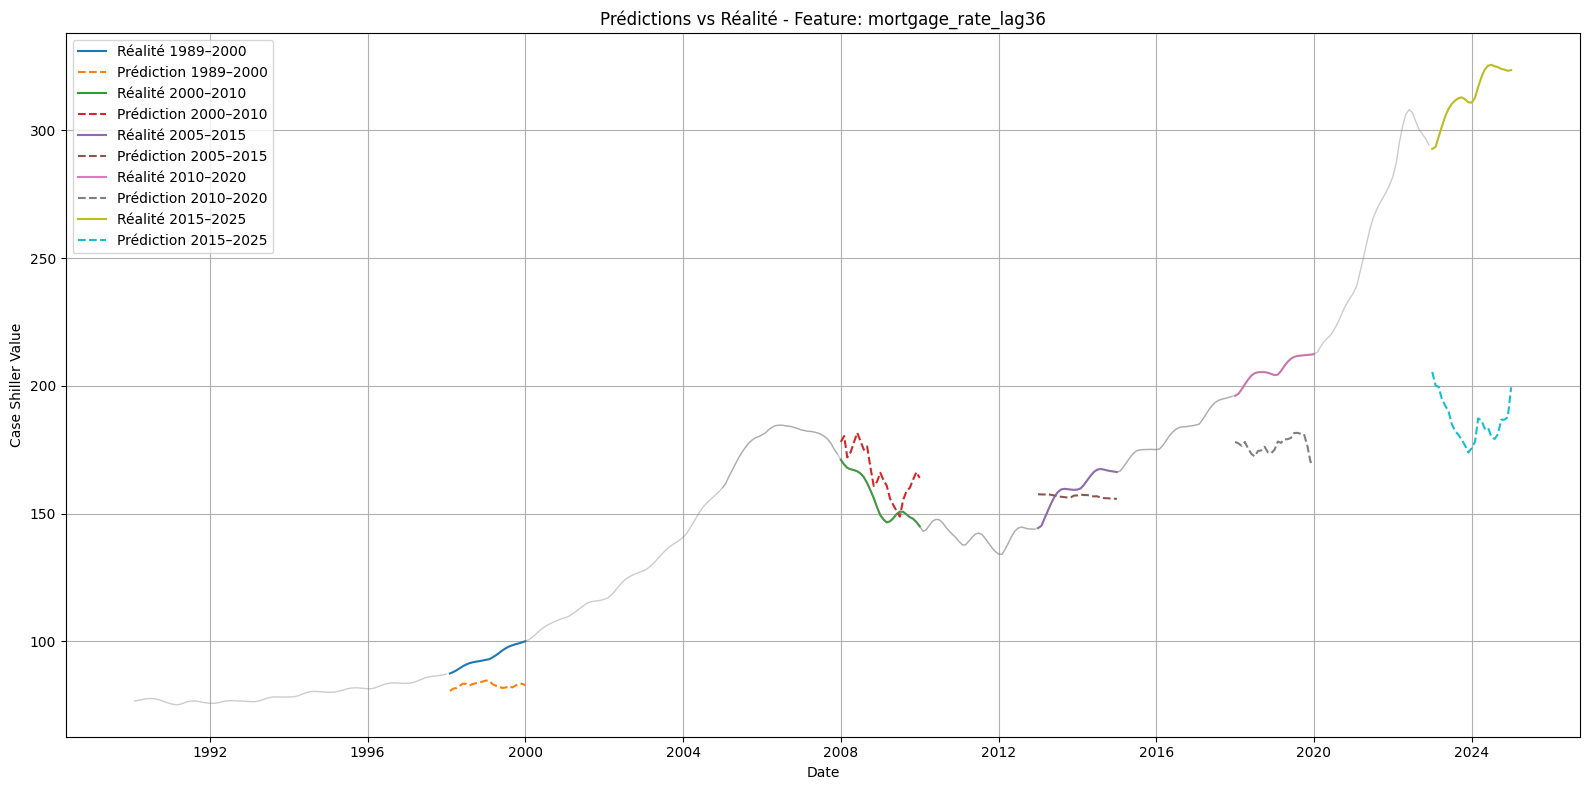

MAE moyen du modèle avec mortgage_rate_lag36: 37.1043
R² moyen du modèle avec mortgage_rate_lag36: -42.8557
Taux de tendance du modèle avec mortgage_rate_lag36: 0.4384


In [24]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "mortgage_rate"]].copy()
df_temp["mortgage_rate_lag36"] = df_temp["mortgage_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(1, 37):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

random_state = 42
# Set the random seed for reproducibility
np.random.seed(random_state)

# Liste pour stocker les R²
r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

# Plot
plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Feature: mortgage_rate_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["case_shiller_value"]
    X_train = train[["mortgage_rate_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["mortgage_rate_lag36"]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_mortgage = np.mean(r2_scores_macro)
trend_model_mortgage = np.mean(trend_scores_macro)
mae_model_mortgage = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec mortgage_rate_lag36: {mae_model_mortgage:.4f}")
print(f"R² moyen du modèle avec mortgage_rate_lag36: {r2_model_mortgage:.4f}")
print(f"Taux de tendance du modèle avec mortgage_rate_lag36: {trend_model_mortgage:.4f}")

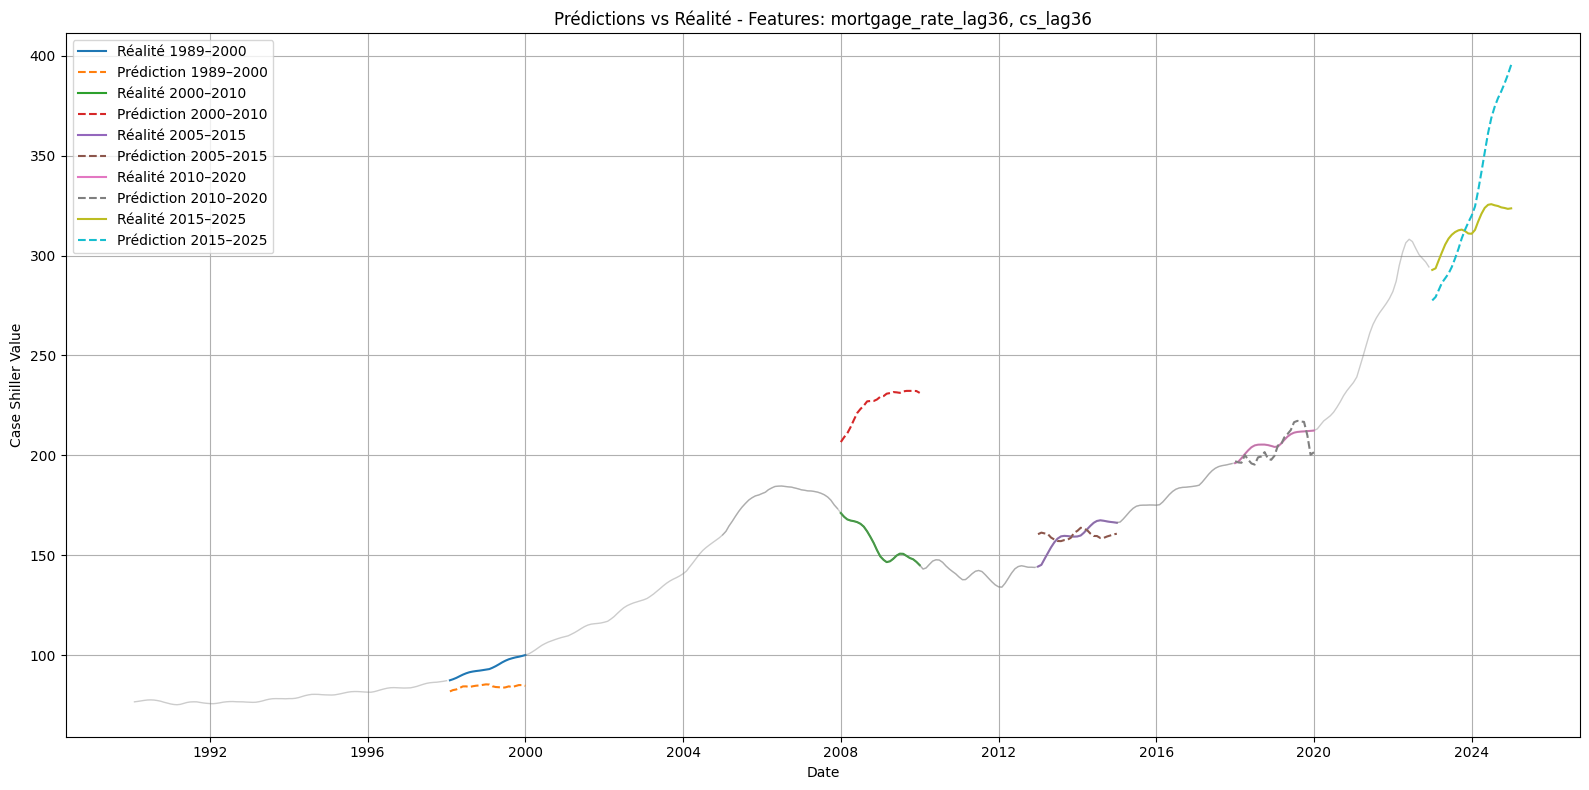

MAE moyen du modèle avec mortgage_rate + cs_lag36 : 23.2976
R² moyen du modèle avec mortgage_rate + cs_lag36 : -16.6016
Taux de tendance du modèle avec mortgage_rate + cs_lag36 : 0.4471


In [25]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "mortgage_rate"]].copy()
df_temp["mortgage_rate_lag36"] = df_temp["mortgage_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(1, 37):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

random_state = 42
# Set the random seed for reproducibility
np.random.seed(random_state)

r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

# Plot
plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Features: mortgage_rate_lag36, cs_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["case_shiller_value"]
    X_train = train[["mortgage_rate_lag36", "cs_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["mortgage_rate_lag36", "cs_lag36"]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_mortgage_cs36 = np.mean(r2_scores_macro)
trend_model_mortgage_cs36 = np.mean(trend_scores_macro)
mae_model_mortgage_cs36 = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec mortgage_rate + cs_lag36 : {mae_model_mortgage_cs36:.4f}")
print(f"R² moyen du modèle avec mortgage_rate + cs_lag36 : {r2_model_mortgage_cs36:.4f}")
print(f"Taux de tendance du modèle avec mortgage_rate + cs_lag36 : {trend_model_mortgage_cs36:.4f}")

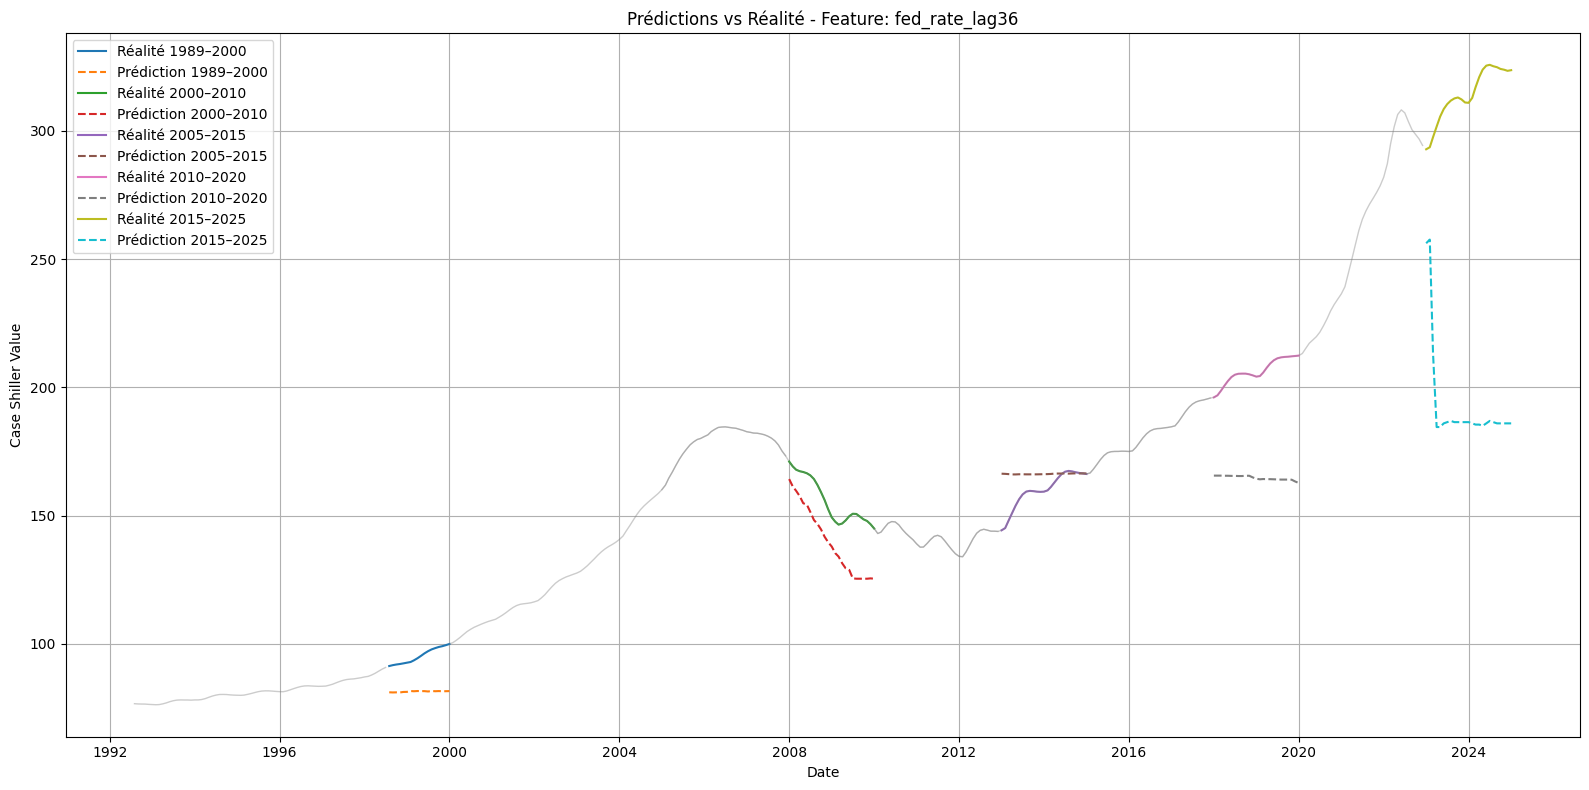

MAE moyen du modèle avec fed_rate : 39.8354
R² moyen du modèle avec fed_rate : -51.0893
Taux de tendance du modèle avec fed_rate : 0.4059


In [26]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Feature: fed_rate_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["case_shiller_value"]
    X_train = train[["fed_rate_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["fed_rate_lag36"]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_fed = np.mean(r2_scores_macro)
trend_model_fed = np.mean(trend_scores_macro)
mae_model_fed = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec fed_rate : {mae_model_fed:.4f}")
print(f"R² moyen du modèle avec fed_rate : {r2_model_fed:.4f}")
print(f"Taux de tendance du modèle avec fed_rate : {trend_model_fed:.4f}")

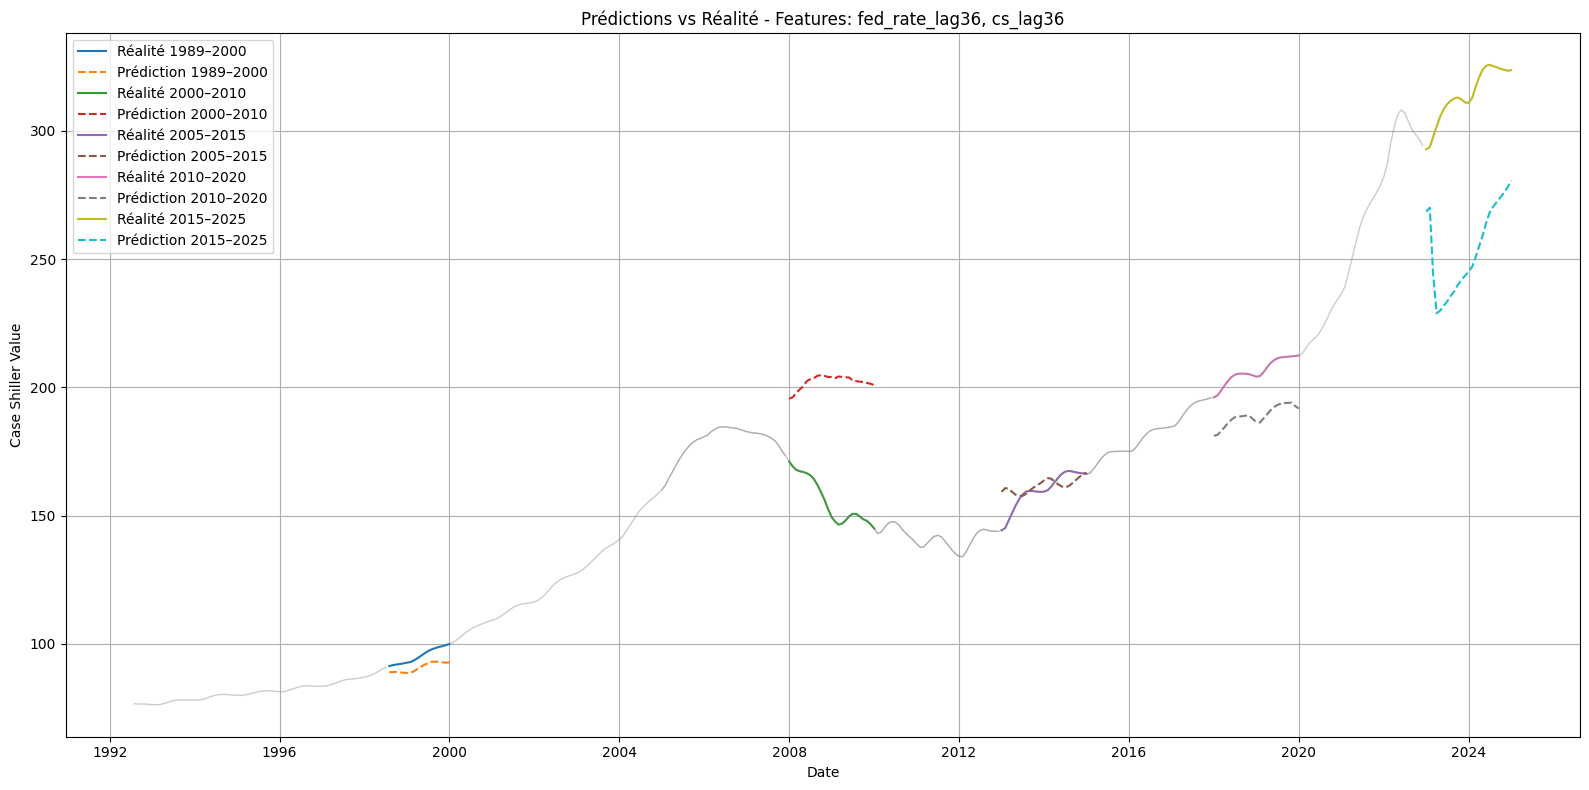

MAE moyen du modèle avec fed_rate + cs_lag36 : 26.5284
R² moyen du modèle avec fed_rate + cs_lag36 : -15.8630
Taux de tendance du modèle avec fed_rate + cs_lag36 : 0.5461


In [27]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Features: fed_rate_lag36, cs_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    # Filtrage de la période
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    # Split train/test (80% train, 20% test)
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    # Y et X
    y_train = train["case_shiller_value"]
    X_train = train[["fed_rate_lag36", "cs_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["fed_rate_lag36", "cs_lag36"]]
    X_test = sm.add_constant(X_test)

    # Régression
    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_fed_cs36 = np.mean(r2_scores_macro)
trend_model_fed_cs36 = np.mean(trend_scores_macro)
mae_model_fed_cs36 = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec fed_rate + cs_lag36 : {mae_model_fed_cs36:.4f}")
print(f"R² moyen du modèle avec fed_rate + cs_lag36 : {r2_model_fed_cs36:.4f}")
print(f"Taux de tendance du modèle avec fed_rate + cs_lag36 : {trend_model_fed_cs36:.4f}")

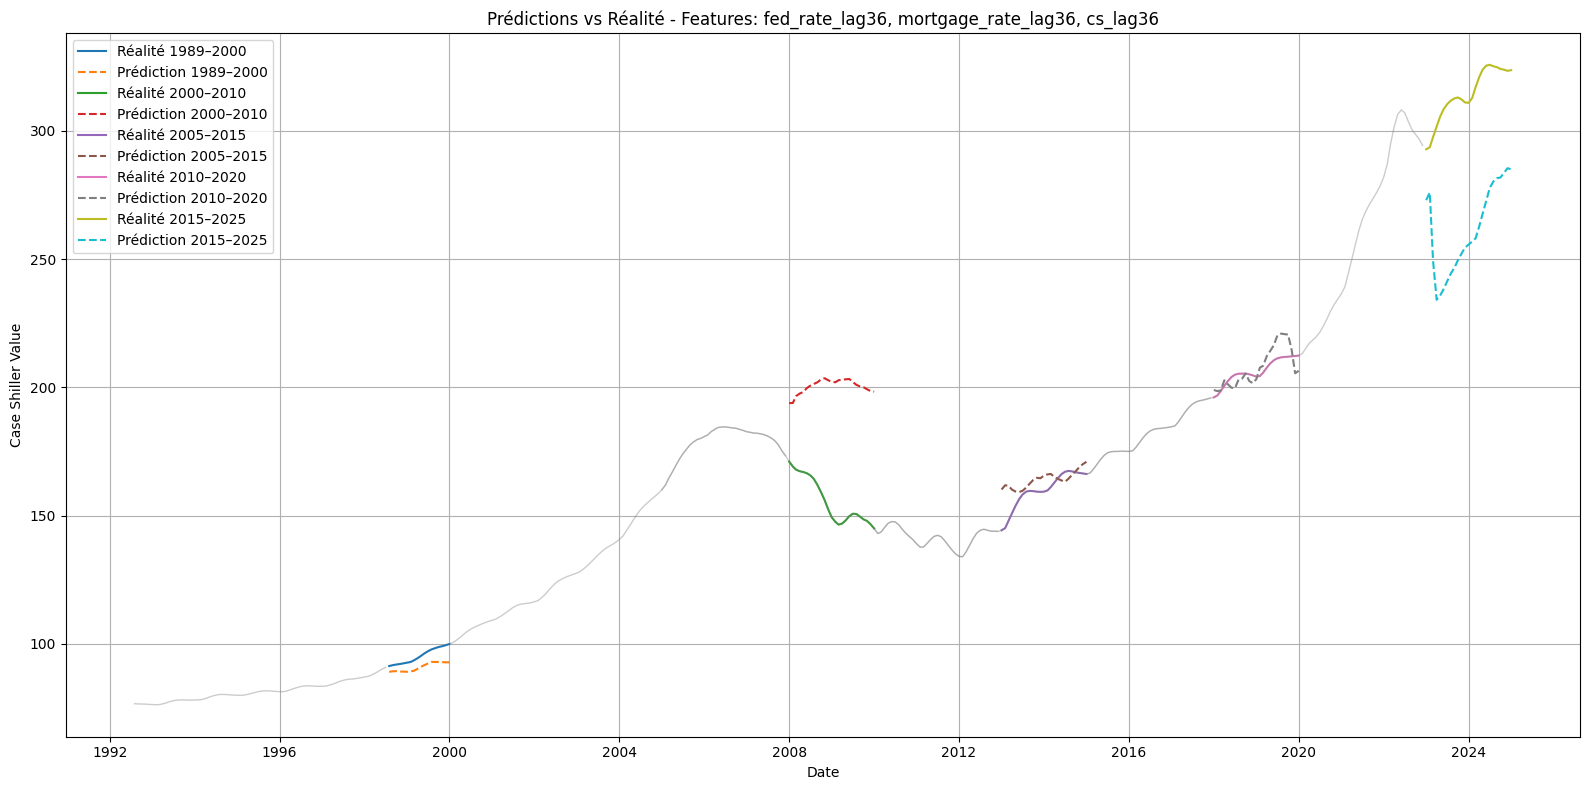

MAE moyen du modèle avec fed_rate + mortgage_rate + cs_lag36 : 22.0533
R² moyen du modèle avec fed_rate + mortgage_rate + cs_lag36 : -11.2075
Trend accuracy moyenne : 52.94%


In [28]:
# Préparation du DataFrame avec lags
df_temp = df_immobilier[["date", "case_shiller_value", "mortgage_rate", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)
df_temp["mortgage_rate_lag36"] = df_temp["mortgage_rate"].shift(36)

# Ajouter 4 lags de case_shiller_value
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Supprimer les lignes incomplètes
df_model = df_temp.dropna().reset_index(drop=True)

r2_scores_macro = []
trend_scores_macro = []
mean_absolute_errors = []

plt.figure(figsize=(16, 8))
plt.title("Prédictions vs Réalité - Features: fed_rate_lag36, mortgage_rate_lag36, cs_lag36")
plt.xlabel("Date")
plt.ylabel("Case Shiller Value")

for start_date, end_date in periods:
    period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
    
    split_idx = int(len(period_df) * 0.8)
    train = period_df.iloc[:split_idx]
    test = period_df.iloc[split_idx:]

    y_train = train["case_shiller_value"]
    X_train = train[["fed_rate_lag36", "mortgage_rate_lag36", "cs_lag36"]]
    X_train = sm.add_constant(X_train)

    y_test = test["case_shiller_value"]
    X_test = test[["fed_rate_lag36", "mortgage_rate_lag36", "cs_lag36"]]
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()
    
    y_test_pred = model.predict(X_test)
    
    # Calcul du R² pour cette période
    r2 = r2_score(y_test, y_test_pred)
    r2_scores_macro.append(r2)
    trend_acc = trend_accuracy(y_test.values, y_test_pred.values)
    trend_scores_macro.append(trend_acc)
    mae = mean_absolute_error(y_test, y_test_pred)
    mean_absolute_errors.append(mae)

    # Tracés
    plt.plot(train["date"], y_train, color='gray', linewidth=1, alpha=0.4)
    plt.plot(test["date"], y_test, label=f"Réalité {start_date[:4]}–{end_date[:4]}")
    plt.plot(test["date"], y_test_pred, linestyle="--", label=f"Prédiction {start_date[:4]}–{end_date[:4]}")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Moyenne du R² sur toutes les périodes
r2_model_fed_mortgage_cs36 = np.mean(r2_scores_macro)
trend_model_fed_mortgage_cs36 = np.mean(trend_scores_macro)
mae_model_fed_mortgage_cs36 = np.mean(mean_absolute_errors)
print(f"MAE moyen du modèle avec fed_rate + mortgage_rate + cs_lag36 : {mae_model_fed_mortgage_cs36:.4f}")
print(f"R² moyen du modèle avec fed_rate + mortgage_rate + cs_lag36 : {r2_model_fed_mortgage_cs36:.4f}")
print(f"Trend accuracy moyenne : {trend_model_fed_mortgage_cs36:.2%}")


# Evaluation

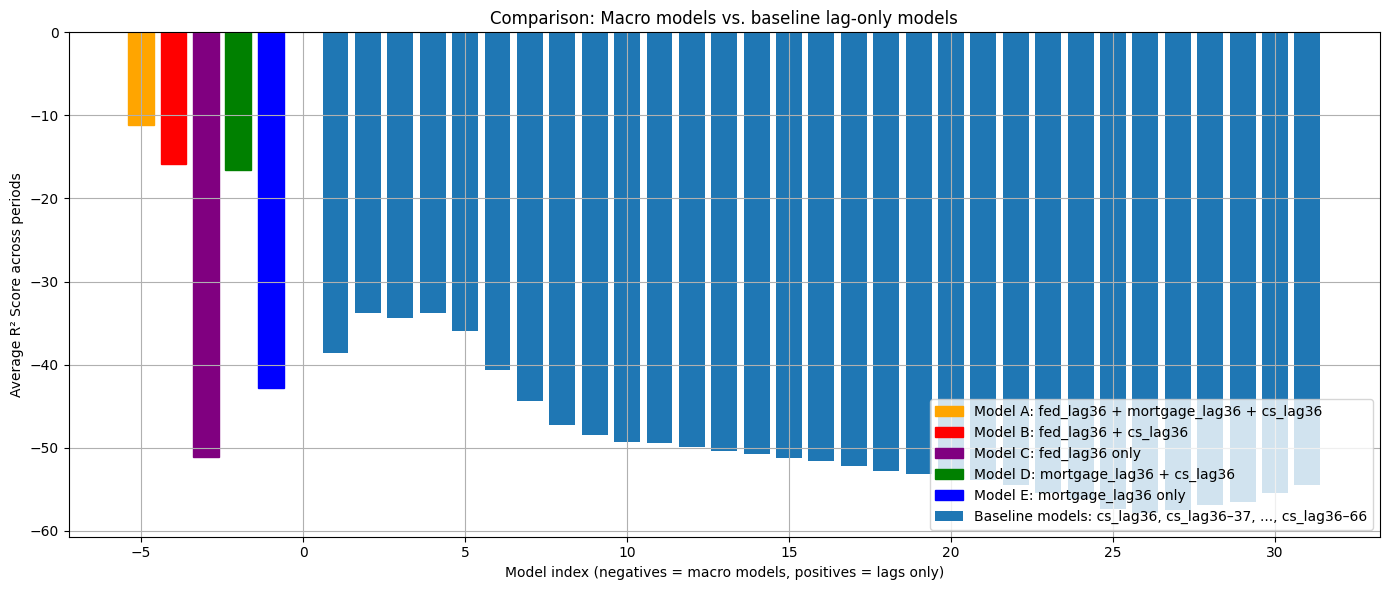

In [29]:
# Base DataFrame
df_temp = df_immobilier[["date", "case_shiller_value", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)

# Range of max lags to test
lag_ranges = [list(range(36, max_lag + 1)) for max_lag in range(36, 67)]

# Add all possible lags in advance
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Remove NaNs
df_model = df_temp.dropna().reset_index(drop=True)

# Store average R² for each lag range
lag_range_scores = []

# Loop over lag sets
for lag_list in lag_ranges:
    features = [f"cs_lag{lag}" for lag in lag_list]
    r2_scores = []

    for start_date, end_date in periods:
        # Period data
        period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
        
        # Train/Test split
        split_idx = int(len(period_df) * 0.8)
        train = period_df.iloc[:split_idx]
        test = period_df.iloc[split_idx:]

        if len(test) == 0 or len(train) == 0:
            continue

        y_train = train["case_shiller_value"]
        X_train = sm.add_constant(train[features])

        y_test = test["case_shiller_value"]
        X_test = sm.add_constant(test[features])

        try:
            model = sm.OLS(y_train, X_train).fit()
            y_test_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_test_pred)
            r2_scores.append(r2)
        except:
            # In case of collinearity or numerical instability
            r2_scores.append(np.nan)

    # Average R² across all periods
    avg_r2 = np.nanmean(r2_scores)
    lag_range_scores.append((len(lag_list), avg_r2))

macro_models = [
    (-5, r2_model_fed_mortgage_cs36),
    (-4, r2_model_fed_cs36),
    (-3, r2_model_fed),
    (-2, r2_model_mortgage_cs36),
    (-1, r2_model_mortgage)
]

# Insérer ces modèles en tête de liste
lag_range_scores = macro_models + lag_range_scores

# DataFrame
r2_df = pd.DataFrame(lag_range_scores, columns=["model_index", "avg_r2"])

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(r2_df["model_index"], r2_df["avg_r2"])

# Color mapping for macro models
macro_colors = {
    -5: "orange",  # fed + mortgage + cs36
    -4: "red",     # fed + cs36
    -3: "purple",  # fed only
    -2: "green",   # mortgage + cs36
    -1: "blue"     # mortgage only
}
labels = {
    -5: "Model A: fed + mortgage + cs_lag36",
    -4: "Model B: fed + cs_lag36",
    -3: "Model C: fed only",
    -2: "Model D: mortgage + cs_lag36",
    -1: "Model E: mortgage only"
}

# Appliquer les couleurs spécifiques
custom_handles = []
for i, bar in enumerate(bars):
    model_idx = r2_df["model_index"].iloc[i]
    if model_idx in macro_colors:
        bar.set_color(macro_colors[model_idx])
        custom_handles.append(bar)

# Légende manuelle (dans le bon ordre)
legend_bars = [bars[r2_df[r2_df["model_index"] == idx].index[0]] for idx in macro_colors]
legend_labels = [labels[idx] for idx in macro_colors]

legend_bars = [
    bars[r2_df[r2_df["model_index"] == -5].index[0]],  # A
    bars[r2_df[r2_df["model_index"] == -4].index[0]],  # B
    bars[r2_df[r2_df["model_index"] == -3].index[0]],  # C
    bars[r2_df[r2_df["model_index"] == -2].index[0]],  # D
    bars[r2_df[r2_df["model_index"] == -1].index[0]],  # E
    bars[5]  # first baseline bar, any blue bar is fine
]

legend_labels = [
    "Model A: fed_lag36 + mortgage_lag36 + cs_lag36",
    "Model B: fed_lag36 + cs_lag36",
    "Model C: fed_lag36 only",
    "Model D: mortgage_lag36 + cs_lag36",
    "Model E: mortgage_lag36 only",
    "Baseline models: cs_lag36, cs_lag36–37, ..., cs_lag36–66"
]

plt.legend(legend_bars, legend_labels, loc="lower right")

# Titre et axes
plt.xlabel("Model index (negatives = macro models, positives = lags only)")
plt.ylabel("Average R² Score across periods")
plt.title("Comparison: Macro models vs. baseline lag-only models")
plt.grid(True)
plt.tight_layout()
plt.show()

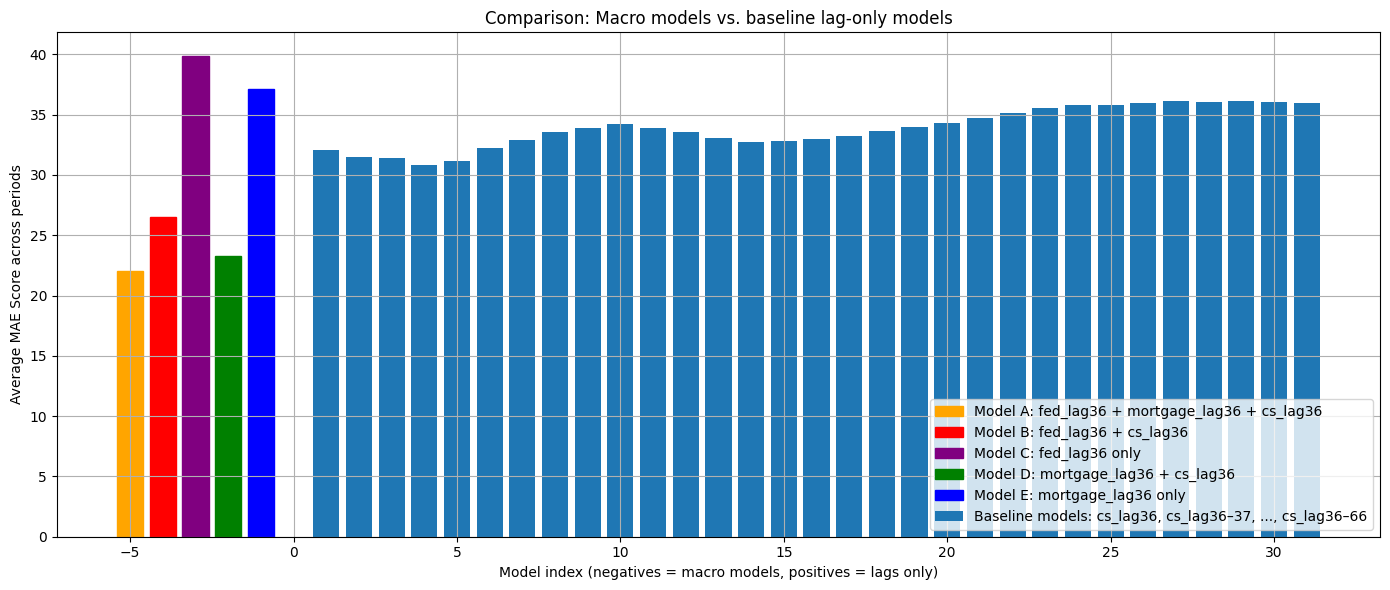

In [30]:
# Base DataFrame
df_temp = df_immobilier[["date", "case_shiller_value", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)

# Range of max lags to test
lag_ranges = [list(range(36, max_lag + 1)) for max_lag in range(36, 67)]

# Add all possible lags in advance
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

# Remove NaNs
df_model = df_temp.dropna().reset_index(drop=True)

# Store average score for each lag range
lag_range_scores = []

# Loop over lag sets
for lag_list in lag_ranges:
    features = [f"cs_lag{lag}" for lag in lag_list]
    mea_scores = []

    for start_date, end_date in periods:
        # Period data
        period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
        
        # Train/Test split
        split_idx = int(len(period_df) * 0.8)
        train = period_df.iloc[:split_idx]
        test = period_df.iloc[split_idx:]

        if len(test) == 0 or len(train) == 0:
            continue

        y_train = train["case_shiller_value"]
        X_train = sm.add_constant(train[features])

        y_test = test["case_shiller_value"]
        X_test = sm.add_constant(test[features])

        try:
            model = sm.OLS(y_train, X_train).fit()
            y_test_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_test_pred)
            mea_scores.append(mae)
        except:
            # In case of collinearity or numerical instability
            mea_scores.append(np.nan)

    # Average mea across all periods
    avg_mea = np.nanmean(mea_scores)
    lag_range_scores.append((len(lag_list), avg_mea))

macro_models = [
    (-5, mae_model_fed_mortgage_cs36),
    (-4, mae_model_fed_cs36),
    (-3, mae_model_fed),
    (-2, mae_model_mortgage_cs36),
    (-1, mae_model_mortgage)
]

# Insérer ces modèles en tête de liste
lag_range_scores = macro_models + lag_range_scores

# DataFrame
mae_df = pd.DataFrame(lag_range_scores, columns=["model_index", "avg_mea"])

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(mae_df["model_index"], mae_df["avg_mea"])

# Color mapping for macro models
macro_colors = {
    -5: "orange",  # fed + mortgage + cs36
    -4: "red",     # fed + cs36
    -3: "purple",  # fed only
    -2: "green",   # mortgage + cs36
    -1: "blue"     # mortgage only
}
labels = {
    -5: "Model A: fed + mortgage + cs_lag36",
    -4: "Model B: fed + cs_lag36",
    -3: "Model C: fed only",
    -2: "Model D: mortgage + cs_lag36",
    -1: "Model E: mortgage only"
}

# Appliquer les couleurs spécifiques
custom_handles = []
for i, bar in enumerate(bars):
    model_idx = mae_df["model_index"].iloc[i]
    if model_idx in macro_colors:
        bar.set_color(macro_colors[model_idx])
        custom_handles.append(bar)

# Légende manuelle (dans le bon ordre)
legend_bars = [bars[mae_df[mae_df["model_index"] == idx].index[0]] for idx in macro_colors]
legend_labels = [labels[idx] for idx in macro_colors]

legend_bars = [
    bars[mae_df[mae_df["model_index"] == -5].index[0]],  # A
    bars[mae_df[mae_df["model_index"] == -4].index[0]],  # B
    bars[mae_df[mae_df["model_index"] == -3].index[0]],  # C
    bars[mae_df[mae_df["model_index"] == -2].index[0]],  # D
    bars[mae_df[mae_df["model_index"] == -1].index[0]],  # E
    bars[5]  # first baseline bar, any blue bar is fine
]

legend_labels = [
    "Model A: fed_lag36 + mortgage_lag36 + cs_lag36",
    "Model B: fed_lag36 + cs_lag36",
    "Model C: fed_lag36 only",
    "Model D: mortgage_lag36 + cs_lag36",
    "Model E: mortgage_lag36 only",
    "Baseline models: cs_lag36, cs_lag36–37, ..., cs_lag36–66"
]

plt.legend(legend_bars, legend_labels, loc="lower right")

# Titre et axes
plt.xlabel("Model index (negatives = macro models, positives = lags only)")
plt.ylabel("Average MAE Score across periods")
plt.title("Comparison: Macro models vs. baseline lag-only models")
plt.grid(True)
plt.tight_layout()
plt.show()

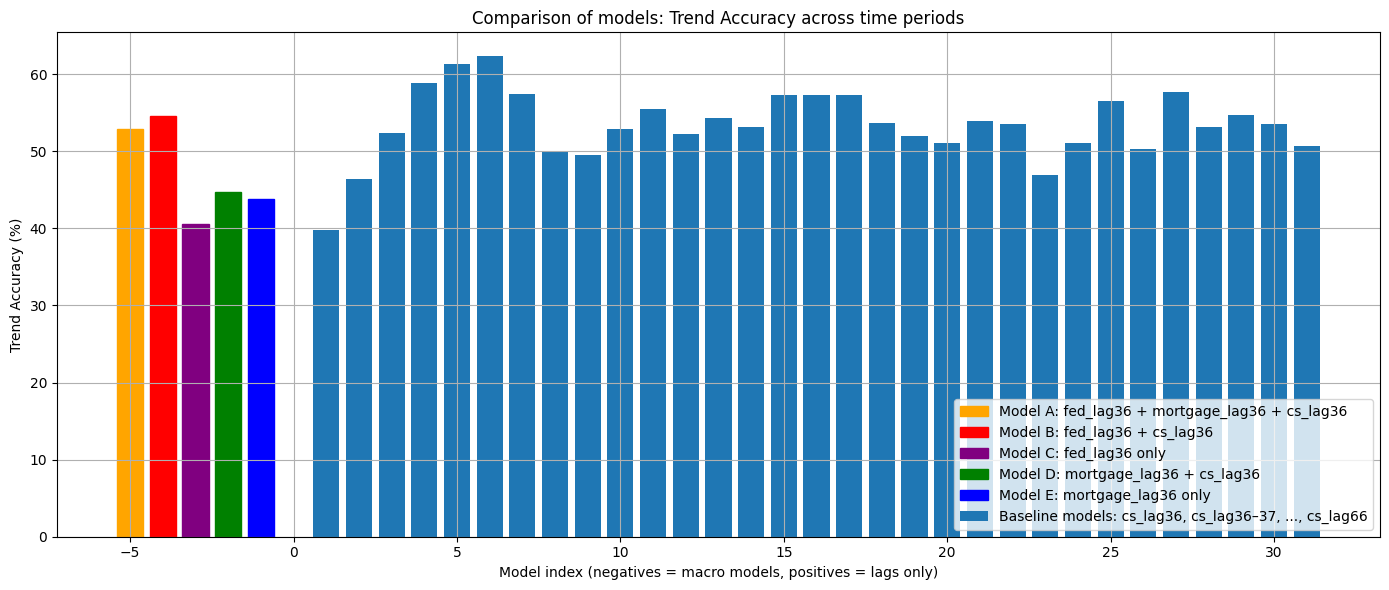

In [31]:
# ----- Préparation -----
df_temp = df_immobilier[["date", "case_shiller_value", "fed_rate"]].copy()
df_temp["fed_rate_lag36"] = df_temp["fed_rate"].shift(36)

# Ajouter les lags
for lag in range(36, 67):
    df_temp[f"cs_lag{lag}"] = df_temp["case_shiller_value"].shift(lag)

df_model = df_temp.dropna().reset_index(drop=True)

# ----- Baseline models -----
lag_ranges = [list(range(36, max_lag + 1)) for max_lag in range(36, 67)]
lag_trend_scores = []

for lag_list in lag_ranges:
    features = [f"cs_lag{lag}" for lag in lag_list]
    trend_scores = []

    for start_date, end_date in periods:
        period_df = df_model[(df_model["date"] >= start_date) & (df_model["date"] <= end_date)].copy()
        split_idx = int(len(period_df) * 0.8)
        train = period_df.iloc[:split_idx]
        test = period_df.iloc[split_idx:]

        if len(test) == 0 or len(train) == 0:
            continue

        y_train = train["case_shiller_value"]
        X_train = sm.add_constant(train[features])
        y_test = test["case_shiller_value"]
        X_test = sm.add_constant(test[features])

        try:
            model = sm.OLS(y_train, X_train).fit()
            y_test_pred = model.predict(X_test)
            score = trend_accuracy(y_test.values, y_test_pred.values)
            trend_scores.append(score)
        except:
            trend_scores.append(np.nan)

    avg_trend = np.nanmean(trend_scores)
    lag_trend_scores.append((len(lag_list), avg_trend))

# ----- Macro models scores (déjà calculés ailleurs dans ton code) -----
macro_trend_scores = [
    (-5, trend_model_fed_mortgage_cs36),
    (-4, trend_model_fed_cs36),
    (-3, trend_model_fed),
    (-2, trend_model_mortgage_cs36),
    (-1, trend_model_mortgage)
]

# ----- Combiner toutes les données -----
trend_df = pd.DataFrame(macro_trend_scores + lag_trend_scores, columns=["model_index", "avg_trend_accuracy"])

# ----- Plot -----
plt.figure(figsize=(14, 6))
bars = plt.bar(trend_df["model_index"], 100 * trend_df["avg_trend_accuracy"])  # en %

# Color mapping macro
macro_colors = {
    -5: "orange",
    -4: "red",
    -3: "purple",
    -2: "green",
    -1: "blue"
}
labels = {
    -5: "Model A: fed_lag36 + mortgage_lag36 + cs_lag36",
    -4: "Model B: fed_lag36 + cs_lag36",
    -3: "Model C: fed_lag36 only",
    -2: "Model D: mortgage_lag36 + cs_lag36",
    -1: "Model E: mortgage_lag36 only"
}

# Appliquer les couleurs
for i, bar in enumerate(bars):
    model_idx = trend_df["model_index"].iloc[i]
    if model_idx in macro_colors:
        bar.set_color(macro_colors[model_idx])

# Légende
legend_bars = [bars[trend_df[trend_df["model_index"] == idx].index[0]] for idx in macro_colors]
legend_labels = [labels[idx] for idx in macro_colors]
legend_labels.append("Baseline models: cs_lag36, cs_lag36–37, ..., cs_lag66")
legend_bars.append(bars[5])  # une barre baseline bleue

plt.legend(legend_bars, legend_labels, loc="lower right")

# Titres et axes
plt.xlabel("Model index (negatives = macro models, positives = lags only)")
plt.ylabel("Trend Accuracy (%)")
plt.title("Comparison of models: Trend Accuracy across time periods")
plt.grid(True)
plt.tight_layout()
plt.show()


# What if: Anticipation des prix immobiliers sur 3 ans

## Les constats clés
- Les variations des taux ont un impact décalé de 36 mois sur les prix immobiliers (corrélation de -0.85)
- Plus la hausse des taux est forte, plus la baisse des prix sera marquée 3 ans plus tard
- Le modèle intégrant les deux taux (Fed et hypothécaire) a le meilleur R² et la meilleure prévision des tendances

## Scénario : Hausse agressive des taux Fed en 2024

Si la Fed décide en 2024 de :
1. Maintenir ses taux à 5.5% pendant 6 mois
2. Les augmenter à 6% pendant 6 mois 
3. Puis à 6.5% jusqu'à fin 2024

### Impact attendu en 2027
- Le Case-Shiller devrait baisser de 15-20% par rapport à son niveau actuel
- Les prix reviendraient au niveau de 2022
- La correction serait plus forte dans les zones où les prix ont le plus augmenté

### Recommandations pour les acteurs du marché
1. Investisseurs : 
    - Reporter les achats immobiliers importants à 2026-2027
    - Préparer la trésorerie pour saisir les opportunités à la baisse

2. Propriétaires actuels :
    - Refinancer maintenant si possible
    - Se préparer à une perte de valeur du patrimoine sur 3 ans

3. Acheteurs potentiels :
    - Constituer un apport plus important
    - Cibler 2027 pour l'achat, quand les prix seront plus bas
    - Surveiller les zones qui corrigeront le plus